In [1]:
## BUSINESS USE CASE -- PLANE CRASHES HAPPEN!! HERE'S HOW YOU CAN AVOID DYING!!

In [2]:
import csv
import pickle
import pandas as pd
import numpy as np
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from collections import Counter
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

from __future__ import print_function, division

# Get pandas and postgres to work together
import psycopg2 as pg
import pandas.io.sql as pd_sql
plt.rc('font', size=18) 

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
with open('airline_crash.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [4]:
state_df = pd.concat([df['Event_Id'], df['Location'].str.split(', ', expand=True)], axis=1)

In [5]:
state_df['City'] = state_df[0]
state_df['State'] = state_df[1]

state_df = state_df.drop([0,1,2,3,4],1)

In [6]:
df.reset_index(inplace=True)
state_df.reset_index(inplace=True)

In [7]:
df = pd.merge(df, state_df, on='index')

df = df.drop(['Location'],1)

In [8]:
df.Latitude = df.Latitude.astype('float')
df.Longitude = df.Longitude.astype('float')
df.Total_Fatal_Injuries = df.Total_Fatal_Injuries.astype('float')
df.Total_Serious_Injuries = df.Total_Serious_Injuries.astype('float')
df.Total_Minor_Injuries = df.Total_Minor_Injuries.astype('float')
df.Total_Uninjured = df.Total_Uninjured.astype('float')
df.Number_Engines = df.Number_Engines.astype('float')

df['Event_Date'] = pd.to_datetime(df['Event_Date'])

In [9]:
df.head()

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
0,0,20180719X01751,Accident,CEN18LA281,2018-07-19,United States,32.540277,-93.745000,DTN,Shreveport Executive,...,NaN,NaN,1.0,VMC,MANEUVERING,Preliminary,07/23/2018,20180719X01751,Shreveport,LA
1,1,20180717X23051,Accident,GAA18CA428,2018-07-17,United States,36.124445,-86.678056,BNA,Nashville Intl,...,NaN,NaN,NaN,VMC,NaN,Preliminary,07/19/2018,20180717X23051,Nashville,TN
2,2,20180717X82154,Accident,CEN18LA276,2018-07-17,United States,29.868056,-95.795000,IWS,West Houston,...,NaN,NaN,1.0,VMC,NaN,Preliminary,07/19/2018,20180717X82154,Katy,TX
3,3,20180716X44947,Accident,GAA18CA427,2018-07-16,United States,26.002222,-80.240000,HWO,NORTH PERRY,...,NaN,1.0,NaN,VMC,NaN,Preliminary,07/23/2018,20180716X44947,Hollywood,FL
4,4,20180716X60511,Accident,GAA18CA424,2018-07-16,United States,39.564722,-85.235555,N/A,NaN,...,NaN,1.0,NaN,NaN,NaN,Preliminary,07/19/2018,20180716X60511,New Castle,IN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81899 entries, 0 to 81898
Data columns (total 34 columns):
index                     81899 non-null int64
Event_Id_x                81899 non-null object
Investigation_Type        81899 non-null object
Accident_Number           81899 non-null object
Event_Date                81899 non-null datetime64[ns]
Country                   81392 non-null object
Latitude                  28059 non-null float64
Longitude                 28050 non-null float64
Airport_Code              46449 non-null object
Airport_Name              51554 non-null object
Injury_Severity           81899 non-null object
Aircraft_Damage           79321 non-null object
Aircraft_Category         25157 non-null object
Registration_Number       78414 non-null object
Make                      81828 non-null object
Model                     81800 non-null object
Amateur_Built             81267 non-null object
Number_Engines            77419 non-null float64
Engine_Type      

In [11]:
df.Broad_Phase_of_Flight.value_counts()

LANDING        19925
TAKEOFF        15767
CRUISE         10911
MANEUVERING    10115
APPROACH        7940
TAXI            2401
CLIMB           2333
DESCENT         2264
GO-AROUND       1667
STANDING        1262
UNKNOWN          738
OTHER            164
Name: Broad_Phase_of_Flight, dtype: int64

In [12]:
df.Broad_Phase_of_Flight.replace('CRUISE', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('MANEUVERING', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('GO-AROUND', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('APPROACH', 'LANDING', inplace=True)
df.Broad_Phase_of_Flight.replace('DESCENT', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('CLIMB', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('STANDING', 'TAXI', inplace=True)

In [13]:
df['Make'] = df['Make'].str.upper()

In [14]:
df[df['Make'] == 'AIRBUS']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
426,426,20180419X80338,Accident,DCA18LA163,2018-04-18,United States,NaN,NaN,ATL,Hartsfield-Jackson,...,NaN,NaN,288.0,NaN,TAKEOFF,Preliminary,05/01/2018,20180419X80338,Atlanta,GA
447,447,20180508X94008,Incident,ENG18WA025,2018-04-14,Australia,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,TAKEOFF,Foreign,NaN,20180508X94008,Brisbane,QLD
725,725,20180205X20338,Incident,ENG18WA011,2018-01-18,Australia,-17.370000,123.660556,asp,Alice Springs,...,NaN,NaN,255.0,NaN,NaN,Foreign,NaN,20180205X20338,Alice Springs,Australia
846,846,20171220X52223,Accident,DCA18CA055,2017-12-06,United States,26.072500,-80.152778,NaN,N/A,...,1.0,1.0,100.0,IMC,INFLIGHT,Probable Cause,06/18/2018,20171220X52223,Fort Lauderdale,FL
862,862,20171212X50255,Accident,DCA18CA043A,2017-12-03,United States,NaN,NaN,MIA,Miami International,...,NaN,NaN,NaN,VMC,NaN,Preliminary,03/07/2018,20171212X50255,Miami,FL
885,885,20171128X93434,Accident,DCA18LA024B,2017-11-27,United States,NaN,NaN,JFK,John F Kennedy International,...,NaN,NaN,NaN,NaN,TAXI,Preliminary,03/09/2018,20171128X93434,Jamaica,NY
1084,1084,20170930X94216,Accident,ENG17RA039,2017-09-30,Canada,NaN,NaN,NaN,N/A,...,NaN,NaN,521.0,NaN,NaN,Foreign,NaN,20170930X94216,Goose Bay,Canada
1085,1085,20171002X95003,Accident,DCA17CA214B,2017-09-30,United States,NaN,NaN,DCA,Reagan National,...,NaN,NaN,NaN,VMC,NaN,Preliminary,03/07/2018,20171002X95003,Washington DC,DC
1387,1387,20170807X70934,Accident,ANC17CA041,2017-08-03,United States,64.467778,-144.915000,NaN,N/A,...,NaN,NaN,2.0,VMC,LANDING,Probable Cause,09/22/2017,20170807X70934,Delta Junction,AK
1580,1580,20170709X81141,Incident,DCA17IA148,2017-07-07,United States,37.615278,-122.358056,SFO,San Francisco International,...,NaN,NaN,NaN,NaN,INFLIGHT,Preliminary,07/24/2017,20170709X81141,San Francisco,CA


In [15]:
df[df['Make'] == 'BOEING']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
127,127,20180615X62948,Accident,GAA18CA354,2018-06-15,United States,42.422223,-87.867778,UGN,WAUKEGAN NATIONAL,...,NaN,NaN,1.0,VMC,NaN,Preliminary,07/03/2018,20180615X62948,WAUKEGAN,IL
250,250,20180529X13624,Incident,ENG18RA029,2018-05-24,Japan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,TAKEOFF,Foreign,NaN,20180529X13624,Kumamoto,Japan
285,285,20180518X90259,Accident,GAA18CA286,2018-05-16,United States,44.827223,-93.461111,FCM,FLYING CLOUD,...,NaN,NaN,2.0,NaN,NaN,Preliminary,05/21/2018,20180518X90259,Minneapolis,MN
331,331,20180507X00658,Accident,DCA18CA169,2018-05-07,United States,39.179167,-76.667223,KBWI,Baltimore/Thurgood Marshall In,...,NaN,NaN,179.0,VMC,NaN,Preliminary,06/22/2018,20180507X00658,Baltimore,MD
431,431,20180417X23642,Accident,DCA18MA142,2018-04-17,United States,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,INFLIGHT,Preliminary,05/03/2018,20180417X23642,Philadelphia,PA
495,495,20180403X83025,Incident,ENG18WA021,2018-03-29,Hong Kong,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,LANDING,Foreign,NaN,20180403X83025,Chek Lap Kok,Hong Kong
632,632,20180213X95634,Incident,DCA18IA092,2018-02-13,United States,NaN,NaN,NaN,NaN,...,NaN,NaN,378.0,NaN,INFLIGHT,Preliminary,03/05/2018,20180213X95634,Honolulu,HI
664,664,20180222X04028,Incident,ENG18RA015,2018-02-05,New Zealand,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,INFLIGHT,Foreign,NaN,20180222X04028,Auckland,New Zealand
677,677,20180206X80222,Incident,DCA18WA088,2018-01-30,Israel,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,LANDING,Foreign,NaN,20180206X80222,Tel Aviv,Israel
700,700,20180205X00724,Incident,ENG18WA010,2018-01-25,Peru,-12.736944,-75.958056,NaN,NaN,...,NaN,NaN,99.0,NaN,NaN,Foreign,NaN,20180205X00724,Lima,Peru


In [16]:
df[df['Make'] == 'BOMBARDIER']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
287,287,20180517X32316,Incident,ENG18WA027,2018-05-16,South Africa,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,INFLIGHT,Foreign,NaN,20180517X32316,Geuteng,South Africa
2496,2496,20170601X12541,Incident,ENG17WA025,2016-11-15,Hong Kong,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,LANDING,Foreign,NaN,20170601X12541,Hong Kong,Hong Kong
2502,2502,20161116X13203,Incident,CEN17WA040,2016-11-14,Panama,NaN,NaN,MPMG,Marcos A. Gelabert Intl.,...,NaN,NaN,2.0,VMC,LANDING,Foreign,NaN,20161116X13203,Albrook,Panama
3624,3624,20160721X05533,Incident,ENG16RA028,2016-04-17,Japan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,NaN,20160721X05533,Fukuoka,Japan
3852,3852,20160224X24110,Incident,DCA16WA099,2016-02-09,Canada,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,INFLIGHT,Foreign,NaN,20160224X24110,Calgary,Alberta
3948,3948,20160108X01550,Accident,DCA16WA045,2016-01-08,Sweden,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,NaN,20160108X01550,Kiruna,Sweden
4070,4070,20160112X00857,Incident,DCA16WA049,2015-12-02,France,NaN,NaN,NaN,Le Bourget,...,NaN,NaN,NaN,NaN,TAKEOFF,Foreign,NaN,20160112X00857,Le Bourget,France
4670,4670,20150903X54524,Incident,DCA15WA182,2015-07-27,Indonesia,NaN,NaN,NaN,NaN,...,NaN,NaN,98.0,NaN,TAXI,Foreign,NaN,20150903X54524,Makassar,Indonesia
5965,5965,20150121X14444,Incident,ENG14IA029,2014-09-13,Yemen,14.764444,42.981945,NaN,N/A,...,NaN,NaN,NaN,UNK,TAKEOFF,Probable Cause,03/08/2016,20150121X14444,Hodeida,Yemen
6169,6169,20140814X52213,Accident,CEN14LA430,2014-08-09,United States,29.526945,-98.471945,SAT,SAN ANTONIO INTL,...,NaN,NaN,80.0,VMC,TAXI,Probable Cause,01/31/2018,20140814X52213,San Antonio,TX


In [17]:
df[df['Make'] == 'CESSNA']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
1,1,20180717X23051,Accident,GAA18CA428,2018-07-17,United States,36.124445,-86.678056,BNA,Nashville Intl,...,NaN,NaN,NaN,VMC,NaN,Preliminary,07/19/2018,20180717X23051,Nashville,TN
3,3,20180716X44947,Accident,GAA18CA427,2018-07-16,United States,26.002222,-80.240000,HWO,NORTH PERRY,...,NaN,1.0,NaN,VMC,NaN,Preliminary,07/23/2018,20180716X44947,Hollywood,FL
10,10,20180712X91417,Accident,CEN18LA273,2018-07-12,United States,NaN,NaN,NaN,N/A,...,NaN,NaN,1.0,VMC,INFLIGHT,Preliminary,07/19/2018,20180712X91417,Rockford,OH
20,20,20180709X65334,Accident,GAA18CA404,2018-07-09,United States,48.608333,-112.376111,CTB,CUT BANK INTL,...,NaN,NaN,2.0,VMC,NaN,Preliminary,07/11/2018,20180709X65334,Cut Bank,MT
22,22,20180709X25845,Accident,GAA18CA396,2018-07-08,United States,35.237222,-120.642500,SBP,SAN LUIS COUNTY RGNL,...,NaN,NaN,3.0,VMC,NaN,Preliminary,07/12/2018,20180709X25845,San Luis Obispo,CA
40,40,20180706X44148,Accident,CEN18WA256,2018-07-04,Austria,NaN,NaN,LOAV,Bad Voslau,...,NaN,NaN,NaN,VMC,TAKEOFF,Foreign,NaN,20180706X44148,Bad Voslau,Austria
42,42,20180705X92917,Accident,GAA18CA391,2018-07-02,United States,42.542777,-83.178889,VLL,OAKLAND/TROY,...,NaN,NaN,1.0,NaN,NaN,Preliminary,07/09/2018,20180705X92917,Troy,MI
47,47,20180702X85608,Accident,GAA18CA390,2018-07-01,United States,31.817223,-97.569445,7F7,Clifton Muni/Isenhower Field,...,NaN,NaN,1.0,NaN,NaN,Preliminary,07/13/2018,20180702X85608,Clifton,TX
48,48,20180701X52605,Accident,GAA18CA388,2018-07-01,United States,25.778334,-80.170278,X44,Miami,...,NaN,1.0,NaN,VMC,NaN,Preliminary,07/11/2018,20180701X52605,Miami,FL
49,49,20180702X85258,Accident,CEN18LA250,2018-07-01,United States,30.498611,-97.969445,RYW,Rusty Allen Airport,...,NaN,NaN,2.0,VMC,LANDING,Preliminary,07/11/2018,20180702X85258,Lago Vista,TX


In [18]:
df[df['Make'] == 'DASSAULT']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
4478,4478,20150831X30510,Accident,WPR15LA253B,2015-08-28,United States,36.099444,-115.162500,LAS,McCarran International,...,NaN,NaN,5.0,VMC,TAXI,Probable Cause,03/23/2017,20150831X30510,Las Vegas,NV
11773,11773,20130327X45938,Incident,CEN11WA692,2011-05-25,Malaysia,3.131667,101.548333,WMSA,Sultan Abdul Aziz Shah/Subang,...,NaN,NaN,3.0,NaN,NaN,Foreign,04/09/2013,20130327X45938,Subang,Malaysia
12691,12691,20101022X34140,Incident,OPS11IA054A,2010-10-20,United States,40.850000,-74.060833,TEB,"Teterboro, New Jersey",...,NaN,NaN,5.0,VMC,TAKEOFF,Probable Cause,10/03/2011,20101022X34140,Teterboro,NJ
14179,14179,20100507X93350,Incident,ENG10WA028,2010-01-21,United Kingdom,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,Foreign,08/25/2010,20100507X93350,London City Airport,United Kingdom
15920,15920,20090227X04200,Accident,CEN09WA177,2009-02-12,Switzerland,NaN,NaN,LSZS,Samedan Airport,...,1.0,0.0,0.0,VMC,NaN,Foreign,03/16/2009,20090227X04200,Samedan,Switzerland
19937,19937,20081219X65325,Incident,ENG07RA012,2007-01-20,United Kingdom,NaN,NaN,LGW,Gatwick International Airport,...,NaN,NaN,2.0,NaN,NaN,Foreign,07/14/2009,20081219X65325,Gatwick,United Kingdom
25558,25558,20100616X61340,Incident,ENG04RA014,2004-03-12,Norway,NaN,NaN,NaN,NaN,...,NaN,NaN,10.0,NaN,NaN,Foreign,05/12/2011,20100616X61340,Roeros,Norway
33217,33217,20001212X21289,Incident,MIA00IA191,2000-06-27,United States,NaN,NaN,FLL,FORT LAUDERDALE INT'L,...,0.0,0.0,2.0,VMC,TAKEOFF,Probable Cause,10/23/2001,20001212X21289,FORT LAUDERDALE,FL
33306,33306,20001212X21326,Accident,NYC00WA161,2000-06-13,Canada,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,IMC,NaN,Foreign,07/07/2000,20001212X21326,PETERBOROUGH,Canada
33776,33776,20001212X20875,Incident,MIA00IA128,2000-04-04,United States,NaN,NaN,OPF,OPA LOCKA,...,0.0,0.0,2.0,VMC,LANDING,Probable Cause,04/06/2001,20001212X20875,OPA LOCKA,FL


In [19]:
df[df['Make'] == 'EMBRAER']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
66,66,20180702X05713,Incident,OPS18IA014,2018-06-27,United States,37.245555,-93.388611,SGF,Springfield-Branson National A,...,NaN,NaN,53.0,VMC,TAKEOFF,Preliminary,07/23/2018,20180702X05713,Springfield,MO
684,684,20180207X92707,Incident,ENG18RA012,2018-01-29,Argentina,-37.933056,-57.581945,SAZM,Astor Piazzola International,...,NaN,NaN,101.0,NaN,TAXI,Foreign,NaN,20180207X92707,Mar Del Plata,Argentina
1183,1183,20170914X93121,Accident,CEN17LA350,2017-09-12,United States,40.437500,-104.633334,GXY,GREELEY-WELD COUNTY,...,NaN,NaN,3.0,VMC,TAXI,Probable Cause,01/25/2018,20170914X93121,Greeley,CO
1643,1643,20170711X20613,Incident,CEN17WA262,2017-06-30,Mexico,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,TAKEOFF,Foreign,NaN,20170711X20613,Mérida,Yucatán
2440,2440,20161205X55455,Incident,ENG17IA005,2016-12-04,United States,29.531389,-98.468334,SAT,SAN ANTONIO INTL,...,NaN,1.0,54.0,VMC,LANDING,Preliminary,12/21/2016,20161205X55455,San Antonio,TX
2463,2463,20161128X95011,Accident,ERA17WA059,2016-11-24,Brazil,-7.040555,-55.402500,NaN,NaN,...,3.0,NaN,NaN,UNK,LANDING,Foreign,NaN,20161128X95011,Novo Progresso,Brazil
2575,2575,20161119X82656,Accident,ERA17WA051,2016-10-25,Brazil,-28.745833,-52.867223,NaN,N/A,...,NaN,NaN,NaN,VMC,TAKEOFF,Foreign,NaN,20161119X82656,Espumoso,Brazil
2752,2752,20161128X93412,Accident,ERA16WA337,2016-09-19,Brazil,-20.020834,-56.448889,NaN,N/A,...,NaN,NaN,NaN,UNK,NaN,Foreign,NaN,20161128X93412,Miranda,Brazil
3035,3035,20160831X14546,Accident,ERA16WA306,2016-07-31,Brazil,-23.333611,-51.129445,SBLO,Londrina Airport,...,NaN,NaN,NaN,NaN,LANDING,Foreign,NaN,20160831X14546,Londrina City,Brazil
3069,3069,20160805X50153,Accident,DCA16CA208,2016-07-26,United States,41.409444,-81.854722,KCLE,Cleveland-Hopkins Internationa,...,1.0,NaN,52.0,VMC,INFLIGHT,Probable Cause,01/23/2017,20160805X50153,Cleveland,OH


In [20]:
df[df['Make'] == 'GULFSTREAM']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
698,698,20180206X20736,Accident,WPR18WA083,2018-01-25,Nigeria,NaN,NaN,NaN,NaN,...,NaN,NaN,7.0,NaN,LANDING,Foreign,NaN,20180206X20736,Abuja,Nigeria
753,753,20180117X35450,Accident,WPR18WA068,2018-01-10,Philippines,NaN,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,LANDING,Foreign,NaN,20180117X35450,Albay,Philippines
1192,1192,20180123X94129,Incident,CEN17WA381,2017-09-10,France,48.971389,2.446666,NaN,NaN,...,NaN,NaN,6.0,NaN,LANDING,Foreign,NaN,20180123X94129,Le Bourget,France
1598,1598,20170705X45040,Accident,ERA17WA230,2017-07-04,Venezuela,11.049722,-64.709444,NaN,N/A,...,NaN,NaN,NaN,VMC,NaN,Foreign,NaN,20170705X45040,Nueva Esparta,Venezuela
2714,2714,20161005X64448,Incident,CEN16WA392,2016-09-26,Spain,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,LANDING,Foreign,NaN,20161005X64448,Barcelona,Spain
3308,3308,20160620X30745,Incident,ERA16WA221,2016-06-16,Colombia,6.171667,-75.424445,SKRG,Jose Maria Cordova Int'l,...,NaN,NaN,5.0,VMC,LANDING,Foreign,NaN,20160620X30745,Rionegro,Colombia
5537,5537,20150120X63409,Incident,CEN15WA110,2015-01-14,United Kingdom,51.875000,0.373611,NaN,NaN,...,NaN,NaN,8.0,NaN,LANDING,Foreign,NaN,20150120X63409,Luton,United Kingdom
5540,5540,20150325X90423,Incident,DCA15WA094,2015-01-13,Hong Kong,NaN,NaN,NaN,NaN,...,NaN,NaN,6.0,NaN,NaN,Foreign,NaN,20150325X90423,Hong Kong,Hong Kong
7379,7379,20140119X32012,Accident,CEN14WA115,2013-10-12,United Kingdom,NaN,NaN,EGSS,Stansted,...,NaN,NaN,5.0,NaN,NaN,Foreign,01/31/2014,20140119X32012,London,United Kingdom
7815,7815,20130731X51126,Accident,ANC13WA071,2013-07-21,Japan,NaN,NaN,NaN,NaN,...,1.0,2.0,NaN,NaN,NaN,Foreign,08/01/2013,20130731X51126,Tajima,Japan


In [21]:
df[df['Make'] == 'HAWKER BEECHCRAFT']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
2306,2306,20170120X75243,Accident,ERA17WA093,2017-01-19,Brazil,-23.224445,-44.720278,SDTK,NaN,...,NaN,NaN,NaN,NaN,UNKNOWN,Foreign,NaN,20170120X75243,Parati,Brazil
8058,8058,20130607X70213,Accident,CEN13FA326,2013-06-07,United States,30.576389,-91.136944,BTR,"BATON ROUGE METROPOLITAN, RYAN",...,NaN,NaN,NaN,VMC,INFLIGHT,Probable Cause,09/15/2014,20130607X70213,Baker,LA
8484,8484,20130304X04608,Accident,CEN13WA184,2013-03-04,France,NaN,NaN,LFLI,Aérodrome d'Annemasse,...,1.0,NaN,NaN,VMC,NaN,Foreign,03/07/2013,20130304X04608,Cranves-Sales,France
9532,9532,20120725X10029,Accident,WPR12LA324,2012-07-20,United States,42.374167,-122.873611,MFR,Rogue Valley Intl-Medford,...,NaN,NaN,2.0,VMC,LANDING,Probable Cause,03/17/2015,20120725X10029,Medford,OR
9868,9868,20120531X02455,Accident,ERA12FA376,2012-05-31,United States,33.038333,-84.776111,NaN,NaN,...,NaN,NaN,NaN,VMC,NaN,Probable Cause,01/15/2013,20120531X02455,Macon,MS
10199,10199,20120404X75417,Accident,ERA12LA268,2012-04-03,Unknown,12.733334,-69.850000,NaN,N/A,...,NaN,NaN,2.0,VMC,NaN,Probable Cause,02/03/2014,20120404X75417,Caribbean Sea,Unknown
10770,10770,20111026X34639,Accident,CEN12FA043,2011-10-26,United States,32.925556,-97.424445,T67,Hicks Airfield,...,3.0,NaN,NaN,VMC,INFLIGHT,Probable Cause,02/13/2014,20111026X34639,Fort Worth,TX
12279,12279,20110215X94429,Accident,CEN11WA190,2011-02-11,Switzerland,46.182778,7.657222,NaN,NaN,...,NaN,NaN,NaN,VMC,NaN,Foreign,02/18/2011,20110215X94429,Forcletta,Switzerland
12485,12485,20101215X74704,Accident,ERA11WA090,2010-12-14,Bahamas,24.945277,-77.581945,MYNN,Lynden Pindling International,...,NaN,NaN,NaN,VMC,NaN,Foreign,12/22/2010,20101215X74704,Nassau,Bahamas
12573,12573,20101202X84126,Accident,CEN11WA088,2010-11-18,Canada,43.864444,-79.362500,NaN,NaN,...,NaN,NaN,NaN,IMC,NaN,Foreign,12/10/2010,20101202X84126,Buttonville,Canada


In [22]:
df[df['Make'] == 'PIAGGIO']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
806,806,20171220X64353,Accident,CEN18CA058,2017-12-18,United States,30.678334,-97.400000,KGTU,Georgetown Municipal,...,NaN,NaN,2.0,IMC,LANDING,Factual,04/11/2018,20171220X64353,Georgetown,TX
7035,7035,20140203X35035,Accident,CEN14LA127,2014-01-31,United States,39.844166,-89.678056,SPI,Abraham Lincoln Capital,...,NaN,NaN,5.0,IMC,NaN,Preliminary,02/26/2014,20140203X35035,Springfield,IL
8290,8290,20130510X41006,Incident,CEN13IA270,2013-04-24,United States,27.905000,-82.687222,KPIE,St Petersburg-Clearwater Inter,...,NaN,NaN,6.0,VMC,LANDING,Probable Cause,03/24/2014,20130510X41006,Clearwater,FL
8893,8893,20121031X31551,Accident,CEN13FA038,2012-10-31,United States,45.208889,-84.990000,N98,Boyne City Municipal Airport,...,NaN,NaN,2.0,IMC,LANDING,Probable Cause,12/05/2014,20121031X31551,Boyne City,MI
9414,9414,20120918X03545,Accident,CEN12WA640,2012-08-04,Netherlands,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,NaN,INFLIGHT,Foreign,09/19/2012,20120918X03545,Hoogeveen,Netherlands
9466,9466,20120730X73433,Accident,WPR12FA332,2012-07-28,United States,35.972778,-115.134444,KHND,Henderson Executive Airport,...,NaN,NaN,4.0,VMC,TAKEOFF,Probable Cause,04/10/2014,20120730X73433,Henderson,NV
12490,12490,20101214X60551,Incident,CEN11IA108,2010-12-13,United States,39.998055,-82.891944,CMH,Port Columbus IAP,...,NaN,NaN,4.0,VMC,LANDING,Probable Cause,03/20/2012,20101214X60551,Columbus,OH
12892,12892,20100914X51417,Accident,ERA10LA478,2010-09-12,United States,27.910000,-82.687222,PIE,St. Petersburg-Clearwater Int.,...,NaN,NaN,2.0,VMC,TAKEOFF,Probable Cause,02/23/2012,20100914X51417,Clearwater,FL
14052,14052,20100302X85127,Accident,ERA10CA156,2010-03-01,United States,36.101389,-79.938055,GSO,Piedmont Triad International,...,NaN,NaN,1.0,VMC,LANDING,Probable Cause,07/22/2010,20100302X85127,Greensboro,NC


In [23]:
df[df['Make'] == 'PILATUS']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
3897,3897,20160216X40423,Accident,GAA16CA129,2016-01-26,United States,33.978334,-83.961667,LZU,GWINNETT COUNTY - BRISCOE FIEL,...,NaN,NaN,1.0,VMC,TAKEOFF,Probable Cause,04/05/2016,20160216X40423,Lawrenceville,GA
4799,4799,20150709X90721,Accident,GAA15CA174,2015-07-08,United States,45.785833,-111.163611,BZN,BOZEMAN YELLOWSTONE INTL,...,NaN,NaN,2.0,VMC,LANDING,Probable Cause,09/11/2015,20150709X90721,Belgrade,MT
5107,5107,20150520X94628,Accident,GAA15CA080,2015-05-12,United States,35.724445,-108.199444,0E8,CROWNPOINT,...,NaN,NaN,3.0,VMC,LANDING,Probable Cause,11/02/2015,20150520X94628,Crownpoint,NM
8636,8636,20130116X83524,Accident,ERA13FA115,2013-01-16,United States,36.113611,-79.420556,BUY,Burlington-Alamance Regional,...,NaN,NaN,NaN,IMC,TAKEOFF,Probable Cause,01/14/2016,20130116X83524,Burlington,NC
9289,9289,20121019X65400,Accident,CEN12WA674,2012-08-24,France,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,11/01/2012,20121019X65400,Solemont (Doubs),France
10100,10100,20130104X75253,Accident,ENG12WA037,2012-04-25,Indonesia,0.417223,116.033889,WALL,"Sepinggan Airport, Balikpapan",...,NaN,NaN,NaN,NaN,NaN,Foreign,11/12/2013,20130104X75253,Muaritan,Indonesia
11774,11774,20111020X72443,Accident,CEN11RA687,2011-05-25,India,28.350000,77.283333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,10/24/2011,20111020X72443,Faridabad Parvatiya Colony,India
12292,12292,20110330X53824,Accident,DCA11WA038,2011-02-08,South Africa,-34.090555,23.327778,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,10/28/2011,20110330X53824,Plettenberg,South Africa
13466,13466,20100623X20115,Accident,CEN10LA338A,2010-06-20,United States,44.716667,-96.250000,CNB,Myers Field Airport,...,NaN,NaN,3.0,VMC,TAXI,Probable Cause,05/11/2011,20100623X20115,Canby,MN
14511,14511,20091130X31031,Accident,CEN10WA058,2009-10-16,Netherlands,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,12/03/2009,20091130X31031,Weert,Netherlands


In [24]:
df.Broad_Phase_of_Flight.value_counts()

LANDING     27865
INFLIGHT    27290
TAKEOFF     15767
TAXI         3663
UNKNOWN       738
OTHER         164
Name: Broad_Phase_of_Flight, dtype: int64

In [25]:
df = df[df['Broad_Phase_of_Flight'] != 'OTHER']
df = df[df['Broad_Phase_of_Flight'] != 'UNKNOWN']

In [26]:
df.Broad_Phase_of_Flight.value_counts()

LANDING     27865
INFLIGHT    27290
TAKEOFF     15767
TAXI         3663
Name: Broad_Phase_of_Flight, dtype: int64

In [27]:
df = df.rename(columns={'Event_Id_x': 'Event_Id'})

df = df.drop(['Event_Id_y'], axis=1)

In [28]:
len(df.Aircraft_Category.unique())

13

In [29]:
real_df = df.dropna(subset=['Investigation_Type','Event_Date',
              'Country', 'Injury_Severity','Make',
              'Aircraft_Category', 'Amateur_Built', 'Number_Engines', 'Engine_Type',
              'Flight_Purpose', 'Total_Fatal_Injuries', 'Total_Serious_Injuries',
              'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition', 'Broad_Phase_of_Flight','City','State'])

real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3683 entries, 16185 to 81888
Data columns (total 33 columns):
index                     3683 non-null int64
Event_Id                  3683 non-null object
Investigation_Type        3683 non-null object
Accident_Number           3683 non-null object
Event_Date                3683 non-null datetime64[ns]
Country                   3683 non-null object
Latitude                  194 non-null float64
Longitude                 194 non-null float64
Airport_Code              1799 non-null object
Airport_Name              2288 non-null object
Injury_Severity           3683 non-null object
Aircraft_Damage           3630 non-null object
Aircraft_Category         3683 non-null object
Registration_Number       3683 non-null object
Make                      3683 non-null object
Model                     3669 non-null object
Amateur_Built             3683 non-null object
Number_Engines            3683 non-null float64
Engine_Type               3683 non

In [30]:
real_df.Aircraft_Category.value_counts()

Airplane      3265
Helicopter     317
Glider          52
Balloon         30
Gyrocraft       17
Ultralight       1
Unknown          1
Name: Aircraft_Category, dtype: int64

In [31]:
real_df.Weather_Condition.value_counts()

VMC    3303
IMC     329
UNK      51
Name: Weather_Condition, dtype: int64

In [32]:
real_df = real_df[real_df['Weather_Condition'] != 'UNK']

In [33]:
real_df = real_df[real_df['Aircraft_Category'] != 'Ultralight']
real_df = real_df[real_df['Aircraft_Category'] != 'Unknown']

In [34]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 16185 to 81888
Data columns (total 33 columns):
index                     3630 non-null int64
Event_Id                  3630 non-null object
Investigation_Type        3630 non-null object
Accident_Number           3630 non-null object
Event_Date                3630 non-null datetime64[ns]
Country                   3630 non-null object
Latitude                  194 non-null float64
Longitude                 194 non-null float64
Airport_Code              1784 non-null object
Airport_Name              2273 non-null object
Injury_Severity           3630 non-null object
Aircraft_Damage           3579 non-null object
Aircraft_Category         3630 non-null object
Registration_Number       3630 non-null object
Make                      3630 non-null object
Model                     3616 non-null object
Amateur_Built             3630 non-null object
Number_Engines            3630 non-null float64
Engine_Type               3630 non

In [35]:
not_plane = real_df[real_df['Aircraft_Category'] != 'Airplane']

In [36]:
not_plane.Broad_Phase_of_Flight.value_counts()

INFLIGHT    212
LANDING     118
TAKEOFF      71
TAXI         13
Name: Broad_Phase_of_Flight, dtype: int64

In [37]:
real_df = real_df[['Event_Id','Investigation_Type','Event_Date',
              'Country', 'Injury_Severity', 'Make',
              'Aircraft_Category', 'Amateur_Built', 'Number_Engines', 'Engine_Type',
              'Flight_Purpose', 'Total_Fatal_Injuries', 'Total_Serious_Injuries',
              'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition', 'Broad_Phase_of_Flight','City','State']]

In [38]:
real_df.State.value_counts()

CA         401
TX         314
AK         202
FL         201
AZ         121
WA         103
CO         103
IL         100
PA          96
NY          92
MO          89
OH          86
MI          86
GA          85
OR          83
LA          78
NM          70
AR          68
MN          67
OK          67
NC          66
AL          62
KS          60
IN          55
MT          55
IA          53
ID          52
WI          51
SC          49
NV          47
NJ          47
UT          47
WY          46
VA          45
KY          45
NE          41
MA          34
MS          34
TN          32
ND          31
MD          27
CT          22
ME          21
NH          19
WV          19
SD          18
HI          12
VT           9
RI           7
DE           4
DC           4
Bahamas      3
PR           1
Name: State, dtype: int64

In [39]:
real_df['Total_Passengers'] = (real_df['Total_Fatal_Injuries'] + real_df['Total_Serious_Injuries'] + 
                                real_df['Total_Minor_Injuries'] + real_df['Total_Uninjured'])

In [40]:
real_df['Total_Passengers'].value_counts()

1.0      1572
2.0      1148
3.0       404
4.0       286
5.0        80
6.0        38
7.0        25
8.0        14
10.0        5
12.0        5
11.0        4
20.0        4
9.0         4
68.0        3
15.0        2
51.0        2
57.0        2
21.0        2
18.0        2
58.0        1
22.0        1
116.0       1
23.0        1
136.0       1
130.0       1
168.0       1
119.0       1
212.0       1
39.0        1
102.0       1
138.0       1
33.0        1
65.0        1
393.0       1
155.0       1
146.0       1
129.0       1
73.0        1
217.0       1
16.0        1
30.0        1
108.0       1
152.0       1
48.0        1
29.0        1
13.0        1
84.0        1
Name: Total_Passengers, dtype: int64

In [41]:
def major_manufacturer(row):
    if row['Make'] == 'AIRBUS':
        return 'Yes'
    elif row['Make'] == 'BOEING':
        return 'Yes'
    elif row['Make'] == 'BOMBARDIER':
        return 'Yes'
    elif row['Make'] == 'CESSNA':
        return 'Yes'
    elif row['Make'] == 'DASSAULT':
        return 'Yes'
    elif row['Make'] == 'EMBRAER':
        return 'Yes'
    elif row['Make'] == 'GULFSTREAM':
        return 'Yes'
    elif row['Make'] == 'HAWKER':
        return 'Yes'
    elif row['Make'] == 'HAWKER BEECHCRAFT':
        return 'Yes'
    elif row['Make'] == 'PIAGGIO':
        return 'Yes'
    elif row['Make'] == 'PILATUS':
        return 'Yes'
    else:
        return 'No'

In [42]:
real_df.apply(lambda row: major_manufacturer(row),axis=1)

16185     No
16254     No
16315     No
16337    Yes
16369     No
16370    Yes
16395     No
16412     No
16418     No
16438     No
16472     No
16480    Yes
16507     No
16540     No
16546    Yes
16569     No
16571     No
16592    Yes
16600    Yes
16621    Yes
16667    Yes
16674     No
16733     No
16802     No
16850     No
16851     No
16857    Yes
16862     No
16895    Yes
16911    Yes
        ... 
81857     No
81858     No
81859     No
81860     No
81861    Yes
81862     No
81864     No
81865     No
81866    Yes
81867     No
81868    Yes
81869     No
81870     No
81871     No
81872    Yes
81873     No
81874    Yes
81875     No
81876    Yes
81877     No
81878     No
81879    Yes
81880     No
81881     No
81882     No
81883    Yes
81884    Yes
81885     No
81887    Yes
81888    Yes
Length: 3630, dtype: object

In [43]:
real_df['Major_manufacturer'] = real_df.apply(lambda row: major_manufacturer(row),axis=1)

In [44]:
real_df['Major_manufacturer'].value_counts()

No     2268
Yes    1362
Name: Major_manufacturer, dtype: int64

In [45]:
def solo_flight(row):
    if row['Total_Passengers'] == 1 :
        return 'Yes'
    else:
        return 'No'

In [46]:
real_df.apply(lambda row: solo_flight(row),axis=1)

16185     No
16254     No
16315     No
16337    Yes
16369    Yes
16370     No
16395    Yes
16412     No
16418     No
16438    Yes
16472     No
16480    Yes
16507    Yes
16540     No
16546     No
16569    Yes
16571     No
16592    Yes
16600    Yes
16621     No
16667    Yes
16674     No
16733    Yes
16802     No
16850     No
16851     No
16857     No
16862    Yes
16895     No
16911     No
        ... 
81857     No
81858     No
81859    Yes
81860    Yes
81861     No
81862     No
81864     No
81865     No
81866     No
81867     No
81868     No
81869    Yes
81870     No
81871     No
81872     No
81873    Yes
81874     No
81875    Yes
81876    Yes
81877     No
81878    Yes
81879    Yes
81880    Yes
81881     No
81882    Yes
81883    Yes
81884     No
81885    Yes
81887     No
81888     No
Length: 3630, dtype: object

In [47]:
real_df['Solo_Flight'] = real_df.apply(lambda row: solo_flight(row),axis=1)

In [48]:
real_df['Solo_Flight'].value_counts()

No     2058
Yes    1572
Name: Solo_Flight, dtype: int64

In [49]:
def commercial_flight(row):
    if row['Total_Passengers'] > 25:
        return 'Yes'
    else:
        return 'No'

In [50]:
real_df.apply(lambda row: commercial_flight(row),axis=1)

16185    No
16254    No
16315    No
16337    No
16369    No
16370    No
16395    No
16412    No
16418    No
16438    No
16472    No
16480    No
16507    No
16540    No
16546    No
16569    No
16571    No
16592    No
16600    No
16621    No
16667    No
16674    No
16733    No
16802    No
16850    No
16851    No
16857    No
16862    No
16895    No
16911    No
         ..
81857    No
81858    No
81859    No
81860    No
81861    No
81862    No
81864    No
81865    No
81866    No
81867    No
81868    No
81869    No
81870    No
81871    No
81872    No
81873    No
81874    No
81875    No
81876    No
81877    No
81878    No
81879    No
81880    No
81881    No
81882    No
81883    No
81884    No
81885    No
81887    No
81888    No
Length: 3630, dtype: object

In [51]:
real_df['Commercial_Flight'] = real_df.apply(lambda row: commercial_flight(row),axis=1)

In [52]:
real_df['Commercial_Flight'].value_counts()

No     3599
Yes      31
Name: Commercial_Flight, dtype: int64

In [53]:
real_df['Flight_Purpose'].value_counts()

Personal                     1980
Unknown                       581
Instructional                 420
Business                      295
Aerial Application            166
Ferry                          70
Executive/Corporate            52
Positioning                    23
Aerial Observation             13
Public Aircraft                 8
Flight Test                     6
External Load                   3
Skydiving                       3
Air Race/Show                   3
Other Work Use                  2
Public Aircraft - Local         2
Public Aircraft - State         1
Public Aircraft - Federal       1
Glider Tow                      1
Name: Flight_Purpose, dtype: int64

In [54]:
real_df.Flight_Purpose.replace('Unknown', 'Other', inplace=True)
real_df.Flight_Purpose.replace('Executive/Corporate', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Aerial Observation', 'Aerial Application', inplace=True)
real_df.Flight_Purpose.replace('Flight Test', 'Instructional', inplace=True)
real_df.Flight_Purpose.replace('Air Race/Show', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Skydiving', 'Business', inplace=True)
real_df.Flight_Purpose.replace('External Load', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - Local', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Other Work Use', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - Federal', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Glider Tow', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - State', 'Business', inplace=True)

In [55]:
real_df['Flight_Purpose'].value_counts()

Personal              1980
Other                  581
Instructional          426
Business               371
Aerial Application     179
Ferry                   70
Positioning             23
Name: Flight_Purpose, dtype: int64

In [56]:
real_df['Was_Fatal'] = real_df['Total_Fatal_Injuries']

fatal = np.array(real_df['Was_Fatal'].values.tolist())

In [57]:
real_df['Was_Fatal'] = np.where(fatal > 0, 'Fatal', fatal).tolist()

In [58]:
new_fatal = np.array(real_df['Was_Fatal'].values.tolist())

new_fatal

array(['0.0', '0.0', '0.0', ..., '0.0', '0.0', '0.0'], dtype='<U5')

In [59]:
real_df['Was_Fatal'] = np.where(new_fatal == '0.0', 'Non-fatal', new_fatal).tolist()

In [60]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Make,Aircraft_Category,Amateur_Built,Number_Engines,Engine_Type,...,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,City,State,Total_Passengers,Major_manufacturer,Solo_Flight,Commercial_Flight,Was_Fatal
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,0.0,VMC,INFLIGHT,Monterey,CA,2.0,No,No,No,Non-fatal
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,2.0,VMC,TAKEOFF,Nacogdoches,TX,2.0,No,No,No,Non-fatal
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,RANS,Airplane,Yes,1.0,Reciprocating,...,0.0,VMC,INFLIGHT,Breckenridge,TX,2.0,No,No,No,Non-fatal
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,CESSNA,Airplane,No,1.0,Reciprocating,...,1.0,VMC,LANDING,Angleton,TX,1.0,Yes,Yes,No,Non-fatal
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,BELL,Helicopter,No,1.0,Turbo Shaft,...,0.0,VMC,INFLIGHT,Cougar,WA,1.0,No,Yes,No,Non-fatal


In [61]:
real_df['Was_Fatal'].value_counts()

Non-fatal    2971
Fatal         659
Name: Was_Fatal, dtype: int64

In [62]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 16185 to 81888
Data columns (total 24 columns):
Event_Id                  3630 non-null object
Investigation_Type        3630 non-null object
Event_Date                3630 non-null datetime64[ns]
Country                   3630 non-null object
Injury_Severity           3630 non-null object
Make                      3630 non-null object
Aircraft_Category         3630 non-null object
Amateur_Built             3630 non-null object
Number_Engines            3630 non-null float64
Engine_Type               3630 non-null object
Flight_Purpose            3630 non-null object
Total_Fatal_Injuries      3630 non-null float64
Total_Serious_Injuries    3630 non-null float64
Total_Minor_Injuries      3630 non-null float64
Total_Uninjured           3630 non-null float64
Weather_Condition         3630 non-null object
Broad_Phase_of_Flight     3630 non-null object
City                      3630 non-null object
State                     363

In [63]:
real_df['Month'] = real_df['Event_Date'].dt.month

In [64]:
real_df.Month.value_counts()

7     433
8     403
5     394
6     357
9     342
4     324
3     275
10    241
11    233
2     223
12    209
1     196
Name: Month, dtype: int64

In [65]:
real_df['Season'] = ((real_df['Month']%12 + 3)//3)

real_df.Season.value_counts()

3    1193
2     993
4     816
1     628
Name: Season, dtype: int64

In [66]:
real_df.Season.replace(1, 'Winter', inplace=True)
real_df.Season.replace(2, 'Spring', inplace=True)
real_df.Season.replace(3, 'Summer', inplace=True)
real_df.Season.replace(4, 'Fall', inplace=True)

In [67]:
real_df.Season.value_counts()

Summer    1193
Spring     993
Fall       816
Winter     628
Name: Season, dtype: int64

In [68]:
fatal_crash_df = real_df[real_df['Was_Fatal'] == 'Fatal']

In [69]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 16185 to 81888
Data columns (total 26 columns):
Event_Id                  3630 non-null object
Investigation_Type        3630 non-null object
Event_Date                3630 non-null datetime64[ns]
Country                   3630 non-null object
Injury_Severity           3630 non-null object
Make                      3630 non-null object
Aircraft_Category         3630 non-null object
Amateur_Built             3630 non-null object
Number_Engines            3630 non-null float64
Engine_Type               3630 non-null object
Flight_Purpose            3630 non-null object
Total_Fatal_Injuries      3630 non-null float64
Total_Serious_Injuries    3630 non-null float64
Total_Minor_Injuries      3630 non-null float64
Total_Uninjured           3630 non-null float64
Weather_Condition         3630 non-null object
Broad_Phase_of_Flight     3630 non-null object
City                      3630 non-null object
State                     363

In [70]:
relative_season_impact = pd.value_counts(fatal_crash_df['Season']) / pd.value_counts(real_df['Season'])

Text(0.5,1,'Fatal Accidents by Season')

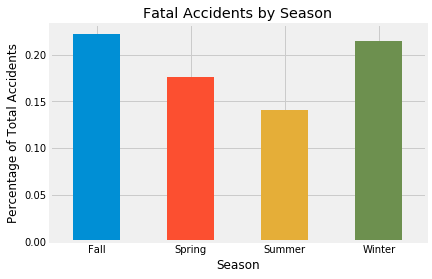

In [71]:
relative_season_impact.plot.bar()
plt.xlabel('Season')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=0)
plt.title("Fatal Accidents by Season")

## Fall and winter have the relatively highest fatal accidents!

In [72]:
amatuer_build_impact = pd.value_counts(fatal_crash_df['Amateur_Built']) / pd.value_counts(real_df['Amateur_Built'])

Text(0.5,1,'Fatal Accidents by Amatuer Built')

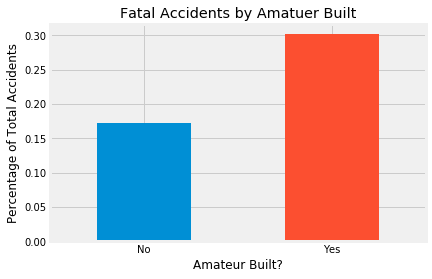

In [73]:
amatuer_build_impact.plot.bar()
plt.xlabel('Amateur Built?')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=0)
plt.title("Fatal Accidents by Amatuer Built")

In [74]:
flight_purpose_impact = pd.value_counts(fatal_crash_df['Flight_Purpose']) / pd.value_counts(real_df['Flight_Purpose'])

Text(0.5,1,'Fatal Accidents by Flight Purpose')

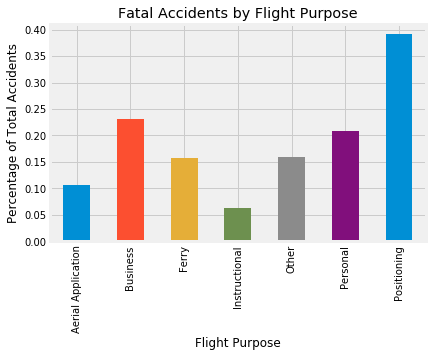

In [75]:
flight_purpose_impact.plot.bar()
plt.xlabel('Flight Purpose')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by Flight Purpose")

In [76]:
weather_impact = pd.value_counts(fatal_crash_df['Weather_Condition']) / pd.value_counts(real_df['Weather_Condition'])

Text(0.5,1,'Fatal Accidents by Weather Condition')

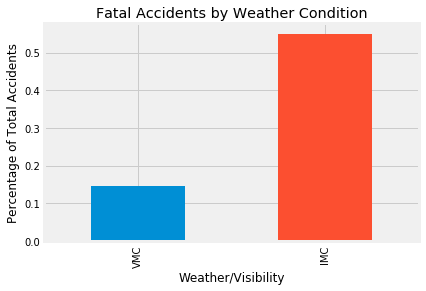

In [77]:
weather_impact.plot.bar()
plt.xlabel('Weather/Visibility')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by Weather Condition")

In [78]:
flight_phase_impact = pd.value_counts(fatal_crash_df['Broad_Phase_of_Flight']) / pd.value_counts(real_df['Broad_Phase_of_Flight'])

Text(0.5,1,'Fatal Accidents by flight phase')

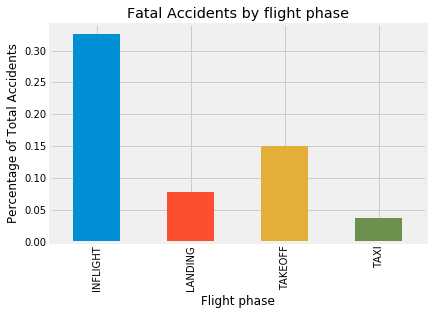

In [79]:
flight_phase_impact.plot.bar()
plt.xlabel('Flight phase')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by flight phase")

In [80]:
aircraft_category_impact = pd.value_counts(fatal_crash_df['Aircraft_Category']) / pd.value_counts(real_df['Aircraft_Category'])

Text(0.5,1,'Fatal Accidents by aircraft category')

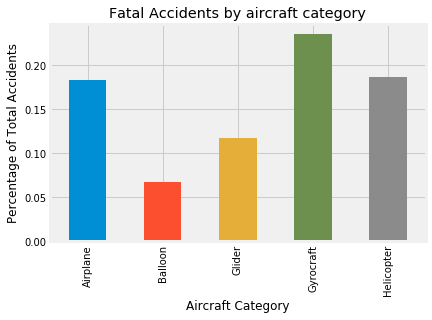

In [81]:
aircraft_category_impact.plot.bar()
plt.xlabel('Aircraft Category')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by aircraft category")

In [82]:
solo_flight_impact = pd.value_counts(fatal_crash_df['Solo_Flight']) / pd.value_counts(real_df['Solo_Flight'])

Text(0.5,1,'Fatal Accidents by solo flight')

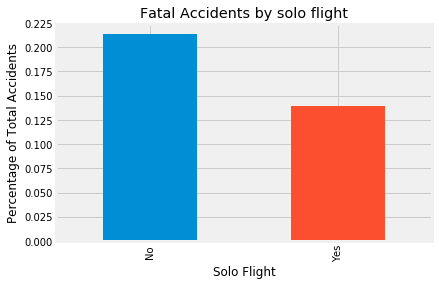

In [83]:
solo_flight_impact.plot.bar()
plt.xlabel('Solo Flight')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by solo flight")

In [84]:
commerical_flight_impact = pd.value_counts(fatal_crash_df['Commercial_Flight']) / pd.value_counts(real_df['Commercial_Flight'])

Text(0.5,1,'Fatal Accidents by commercial flight')

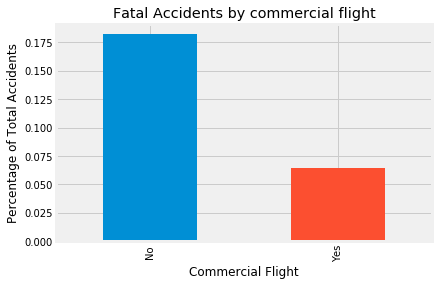

In [85]:
commerical_flight_impact.plot.bar()
plt.xlabel('Commercial Flight')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by commercial flight")

In [86]:
engine_type_impact = pd.value_counts(fatal_crash_df['Engine_Type']) / pd.value_counts(real_df['Engine_Type'])

Text(0.5,1,'Fatal Accidents by engine type')

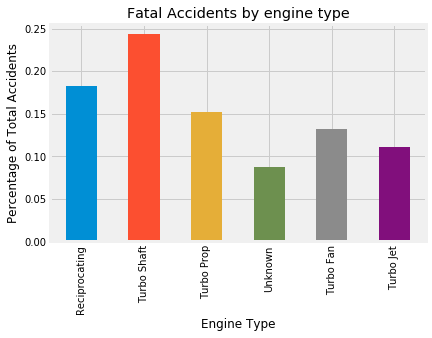

In [87]:
engine_type_impact.plot.bar()
plt.xlabel('Engine Type')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by engine type")

In [88]:
manufacturer_impact = pd.value_counts(fatal_crash_df['Major_manufacturer']) / pd.value_counts(real_df['Major_manufacturer'])

Text(0.5,1,'Fatal Accidents by major manufacturer')

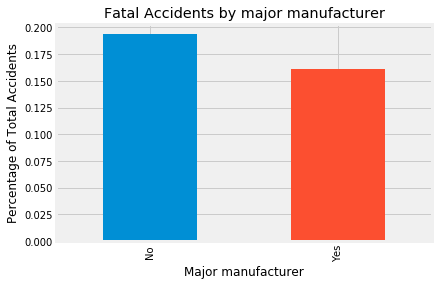

In [89]:
manufacturer_impact.plot.bar()
plt.xlabel('Major manufacturer')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by major manufacturer")

In [90]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 16185 to 81888
Data columns (total 26 columns):
Event_Id                  3630 non-null object
Investigation_Type        3630 non-null object
Event_Date                3630 non-null datetime64[ns]
Country                   3630 non-null object
Injury_Severity           3630 non-null object
Make                      3630 non-null object
Aircraft_Category         3630 non-null object
Amateur_Built             3630 non-null object
Number_Engines            3630 non-null float64
Engine_Type               3630 non-null object
Flight_Purpose            3630 non-null object
Total_Fatal_Injuries      3630 non-null float64
Total_Serious_Injuries    3630 non-null float64
Total_Minor_Injuries      3630 non-null float64
Total_Uninjured           3630 non-null float64
Weather_Condition         3630 non-null object
Broad_Phase_of_Flight     3630 non-null object
City                      3630 non-null object
State                     363

In [91]:
dummy_df = real_df[['Season', 'Aircraft_Category', 'Amateur_Built', 'Engine_Type',
                    'Flight_Purpose', 'Weather_Condition', 'Broad_Phase_of_Flight',
                    'Solo_Flight', 'Major_manufacturer', 'Commercial_Flight']]

In [92]:
dummy_df = pd.get_dummies(dummy_df)

In [93]:
# dummy_df.reset_index(inplace=True)
# real_df.reset_index(inplace=True)

In [94]:
dummy_df.head()

,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Aircraft_Category_Airplane,Aircraft_Category_Balloon,Aircraft_Category_Glider,Aircraft_Category_Gyrocraft,Aircraft_Category_Helicopter,Amateur_Built_No,...,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes,Major_manufacturer_No,Major_manufacturer_Yes,Commercial_Flight_No,Commercial_Flight_Yes
16185,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,1,0,1,0,1,0
16254,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0
16315,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
16337,1,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,1,1,0
16369,1,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,1,1,0,1,0


In [95]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Make,Aircraft_Category,Amateur_Built,Number_Engines,Engine_Type,...,Broad_Phase_of_Flight,City,State,Total_Passengers,Major_manufacturer,Solo_Flight,Commercial_Flight,Was_Fatal,Month,Season
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,INFLIGHT,Monterey,CA,2.0,No,No,No,Non-fatal,11,Fall
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,TAKEOFF,Nacogdoches,TX,2.0,No,No,No,Non-fatal,11,Fall
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,RANS,Airplane,Yes,1.0,Reciprocating,...,INFLIGHT,Breckenridge,TX,2.0,No,No,No,Non-fatal,10,Fall
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,CESSNA,Airplane,No,1.0,Reciprocating,...,LANDING,Angleton,TX,1.0,Yes,Yes,No,Non-fatal,10,Fall
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,BELL,Helicopter,No,1.0,Turbo Shaft,...,INFLIGHT,Cougar,WA,1.0,No,Yes,No,Non-fatal,10,Fall


In [96]:
real_df = real_df.join(dummy_df)

In [97]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Make,Aircraft_Category,Amateur_Built,Number_Engines,Engine_Type,...,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes,Major_manufacturer_No,Major_manufacturer_Yes,Commercial_Flight_No,Commercial_Flight_Yes
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,1,0,0,0,1,0,1,0,1,0
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,0,0,1,0,1,0,1,0,1,0
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,RANS,Airplane,Yes,1.0,Reciprocating,...,1,0,0,0,1,0,1,0,1,0
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,CESSNA,Airplane,No,1.0,Reciprocating,...,0,1,0,0,0,1,0,1,1,0
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,BELL,Helicopter,No,1.0,Turbo Shaft,...,1,0,0,0,0,1,1,0,1,0


In [98]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 16185 to 81888
Data columns (total 62 columns):
Event_Id                             3630 non-null object
Investigation_Type                   3630 non-null object
Event_Date                           3630 non-null datetime64[ns]
Country                              3630 non-null object
Injury_Severity                      3630 non-null object
Make                                 3630 non-null object
Aircraft_Category                    3630 non-null object
Amateur_Built                        3630 non-null object
Number_Engines                       3630 non-null float64
Engine_Type                          3630 non-null object
Flight_Purpose                       3630 non-null object
Total_Fatal_Injuries                 3630 non-null float64
Total_Serious_Injuries               3630 non-null float64
Total_Minor_Injuries                 3630 non-null float64
Total_Uninjured                      3630 non-null float64
Weath

In [99]:
real_df.columns

Index(['Event_Id', 'Investigation_Type', 'Event_Date', 'Country',
       'Injury_Severity', 'Make', 'Aircraft_Category', 'Amateur_Built',
       'Number_Engines', 'Engine_Type', 'Flight_Purpose',
       'Total_Fatal_Injuries', 'Total_Serious_Injuries',
       'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition',
       'Broad_Phase_of_Flight', 'City', 'State', 'Total_Passengers',
       'Major_manufacturer', 'Solo_Flight', 'Commercial_Flight', 'Was_Fatal',
       'Month', 'Season', 'Season_Fall', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'Aircraft_Category_Airplane',
       'Aircraft_Category_Balloon', 'Aircraft_Category_Glider',
       'Aircraft_Category_Gyrocraft', 'Aircraft_Category_Helicopter',
       'Amateur_Built_No', 'Amateur_Built_Yes', 'Engine_Type_Reciprocating',
       'Engine_Type_Turbo Fan', 'Engine_Type_Turbo Jet',
       'Engine_Type_Turbo Prop', 'Engine_Type_Turbo Shaft',
       'Engine_Type_Unknown', 'Flight_Purpose_Aerial Application',
     

In [100]:
target_count = real_df['Was_Fatal'].value_counts()
print(f'Non-Fatal: {target_count[0]}')
print(f'Fatal: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Non-Fatal: 2971
Fatal: 659
Proportion: 4.51 : 1
Percentage of Majority Class: 81.85


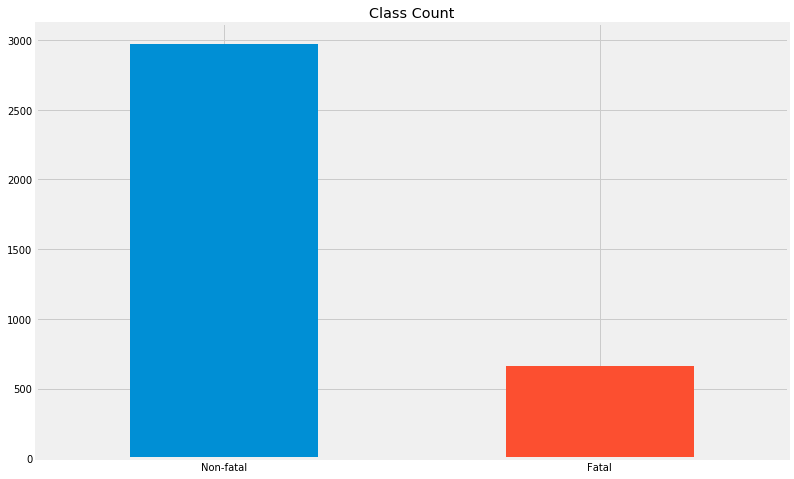

In [101]:
target_count.plot(kind='bar', title='Class Count', rot=0);
plt.gcf().set_size_inches(12,8)

In [435]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

SyntaxError: EOL while scanning string literal (<ipython-input-435-3eb20b41ae1a>, line 34)

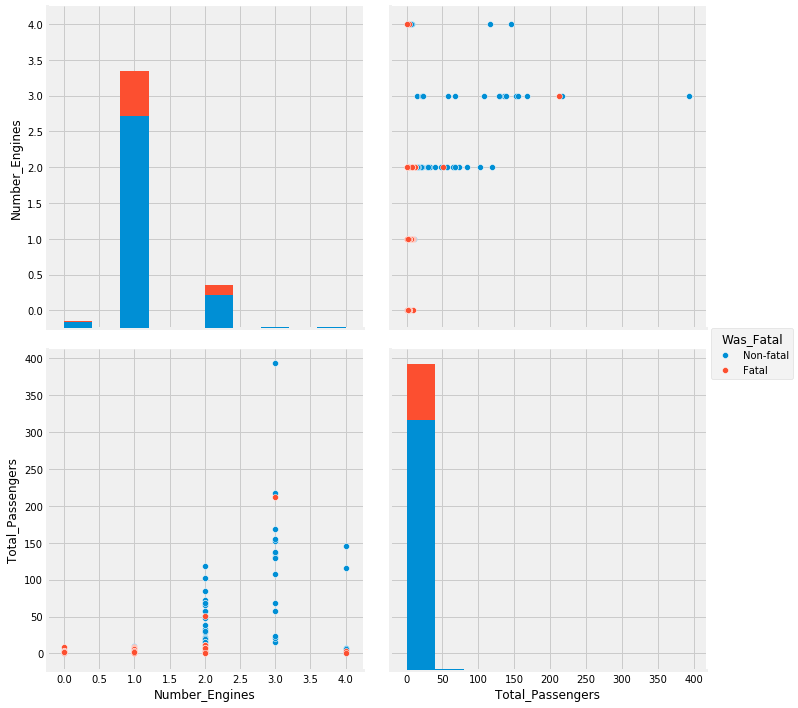

In [103]:
numerical_df = real_df[['Number_Engines','Total_Passengers','Was_Fatal']]

sns.pairplot(numerical_df, hue='Was_Fatal', size=5);

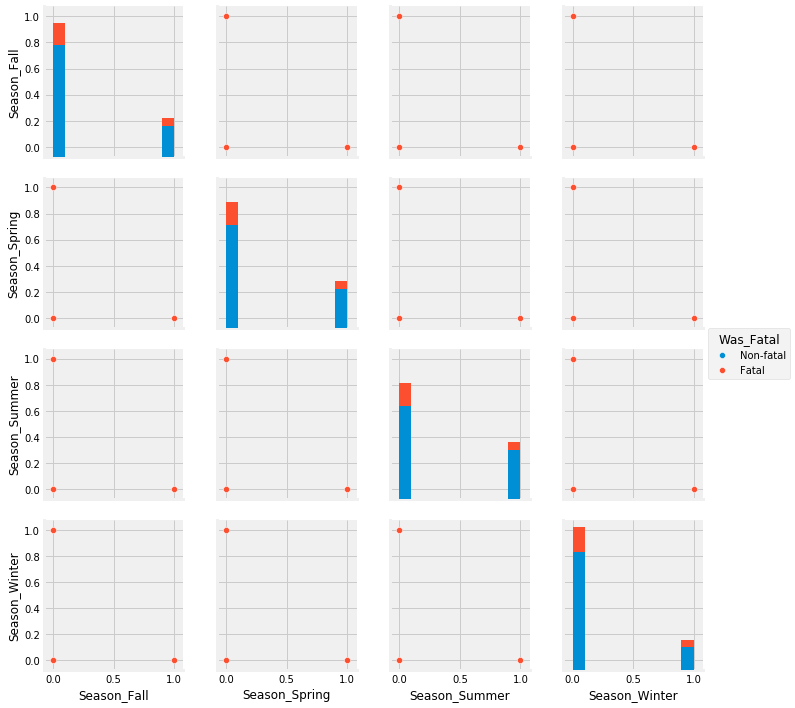

In [104]:
season_df = real_df[['Was_Fatal','Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter']]

sns.pairplot(season_df, hue='Was_Fatal');

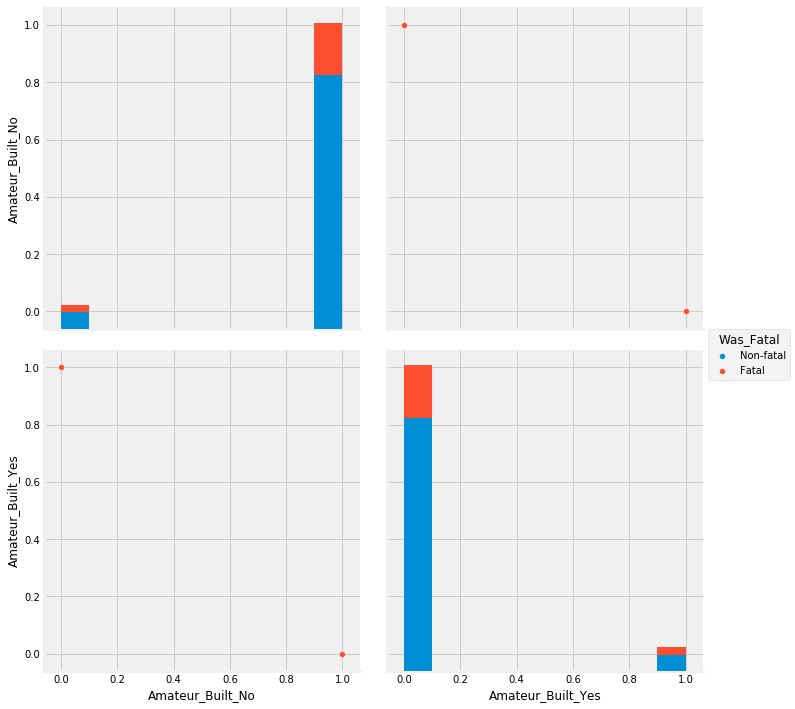

In [105]:
amateur_df = real_df[['Was_Fatal','Amateur_Built_No', 'Amateur_Built_Yes']]

sns.pairplot(amateur_df, hue='Was_Fatal', size=5);

# END OF EDA / START OF ANALYSIS

In [325]:
y = real_df['Was_Fatal']
X = real_df[['Number_Engines','Total_Passengers', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes','Major_manufacturer_No',
       'Major_manufacturer_Yes', 'Commercial_Flight_No',
       'Commercial_Flight_Yes']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [326]:
X_train.head()

,Number_Engines,Total_Passengers,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Aircraft_Category_Airplane,Aircraft_Category_Balloon,Aircraft_Category_Glider,Aircraft_Category_Gyrocraft,...,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes,Major_manufacturer_No,Major_manufacturer_Yes,Commercial_Flight_No,Commercial_Flight_Yes
78422,1.0,1.0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,1,1,0,1,0
81871,1.0,2.0,0,0,0,1,1,0,0,0,...,1,0,0,0,1,0,1,0,1,0
81838,1.0,1.0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,1,0,1,1,0
80664,1.0,4.0,0,1,0,0,1,0,0,0,...,0,0,1,0,1,0,1,0,1,0
79781,1.0,1.0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,1,1,0,1,0


In [327]:
ssX = StandardScaler()
X_train_scalable = X_train.filter(['Number_Engines','Total_Passengers'], axis=1)
X_train_scaled_columns = pd.DataFrame(ssX.fit_transform(X_train_scalable), columns = ['Number_Engines_Scaled','Total_Passengers_Scaled'])

X_train.reset_index(inplace=True)
X_train = X_train.join(X_train_scaled_columns)
X_train = X_train.drop(['Number_Engines','Total_Passengers'],1)

X_train = X_train.set_index('index')

X_test_scalable = X_FINALtest.filter(['Number_Engines','Total_Passengers'], axis=1)
X_test_scaled_columns = pd.DataFrame(ssX.transform(X_test_scalable), columns = ['Number_Engines_Scaled','Total_Passengers_Scaled'])

X_FINALtest.reset_index(inplace=True)
X_FINALtest = X_FINALtest.join(X_test_scaled_columns)
X_FINALtest = X_FINALtest.drop(['Number_Engines','Total_Passengers'],1)

X_FINALtest = X_FINALtest.set_index('index')

In [328]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2722 entries, 78422 to 81816
Data columns (total 38 columns):
Season_Fall                          2722 non-null uint8
Season_Spring                        2722 non-null uint8
Season_Summer                        2722 non-null uint8
Season_Winter                        2722 non-null uint8
Aircraft_Category_Airplane           2722 non-null uint8
Aircraft_Category_Balloon            2722 non-null uint8
Aircraft_Category_Glider             2722 non-null uint8
Aircraft_Category_Gyrocraft          2722 non-null uint8
Aircraft_Category_Helicopter         2722 non-null uint8
Amateur_Built_No                     2722 non-null uint8
Amateur_Built_Yes                    2722 non-null uint8
Engine_Type_Reciprocating            2722 non-null uint8
Engine_Type_Turbo Fan                2722 non-null uint8
Engine_Type_Turbo Jet                2722 non-null uint8
Engine_Type_Turbo Prop               2722 non-null uint8
Engine_Type_Turbo Shaft          

In [329]:
X_FINALtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 908 entries, 81519 to 81230
Data columns (total 38 columns):
Season_Fall                          908 non-null uint8
Season_Spring                        908 non-null uint8
Season_Summer                        908 non-null uint8
Season_Winter                        908 non-null uint8
Aircraft_Category_Airplane           908 non-null uint8
Aircraft_Category_Balloon            908 non-null uint8
Aircraft_Category_Glider             908 non-null uint8
Aircraft_Category_Gyrocraft          908 non-null uint8
Aircraft_Category_Helicopter         908 non-null uint8
Amateur_Built_No                     908 non-null uint8
Amateur_Built_Yes                    908 non-null uint8
Engine_Type_Reciprocating            908 non-null uint8
Engine_Type_Turbo Fan                908 non-null uint8
Engine_Type_Turbo Jet                908 non-null uint8
Engine_Type_Turbo Prop               908 non-null uint8
Engine_Type_Turbo Shaft              908 non-null

In [330]:
## THIS IS JUST USING DEFAULTS FOR EACH TYPE -- NEED TO TUNE HYPERPARAMETERS

X_temptrain, X_temptest, y_temptrain, y_temptest = train_test_split(X_train, y_train, test_size=0.3, random_state=4444)

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):    
    models[i].fit(X_temptrain, y_temptrain)
    y_predict = models[i].predict(X_temptest)
    accuracy = np.round(accuracy_score(y_temptest, y_predict), 4)
    precision = np.round(precision_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    recall = np.round(recall_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    f1 = np.round(f1_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    print(f'{names[i]} acc: {accuracy} prec: {precision} recall: {recall} f1-score: {f1}')
    print('')

LR acc: 0.8409 prec: 0.64 recall: 0.2222 f1-score: 0.3299

KNN acc: 0.8164 prec: 0.4516 recall: 0.1944 f1-score: 0.2718

NB acc: 0.366 prec: 0.2105 recall: 0.9444 f1-score: 0.3443

SVC acc: 0.8311 prec: 0.5429 recall: 0.2639 f1-score: 0.3551

Decision Tree acc: 0.7723 prec: 0.3409 recall: 0.3125 f1-score: 0.3261

Random Forest acc: 0.7956 prec: 0.3814 recall: 0.2569 f1-score: 0.3071

Gradient Boosted Trees acc: 0.8299 prec: 0.5455 recall: 0.2083 f1-score: 0.3015



In [331]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.822556943423953, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')
logistic: best score: 0.8357825128581925, best estimator: LogisticRegression(C=1.873817422860385, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.8339456282145481, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.8324761204996326, best

In [332]:
from sklearn.feature_selection import SelectKBest, RFE, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

def feature_selection(X, y, count):

    # Feature Importance from Random Forest
    ET = ExtraTreesClassifier()
    ET.fit(X, y)    
    importances = list(zip(ET.feature_importances_, X.columns))
    importances.sort(reverse=True)
    FI_features = [x[1] for x in importances][0:count]
    
    # RANDOM FOREST FEATURE IMPORTANCE
    RF = RandomForestClassifier()
    RF.fit(X, y)    
    importances = list(zip(RF.feature_importances_, X.columns))
    importances.sort(reverse=True)
    RF_features = [x[1] for x in importances][0:count]

    # Recursive Feature Elimination
    lr = LogisticRegression()
    rfe = RFE(lr, count)
    fit = rfe.fit(X, y)
    RLR_features = list(X.columns[fit.support_])

    # PCA
#     pca = PCA(n_components=5)
#     fit = pca.fit(X)    
#     df = pd.DataFrame(pca.components_,columns=X.columns).abs().mean().sort_values(ascending = False)
#     PCA_features = list(df.index.values)[0:7]
    
    feats = pd.DataFrame(
        {
         'ExtraTrees FI': FI_features,
         'Recursive LogReg': RLR_features,
         'Random Forest FI': RF_features
#          'PCA': PCA_features
        })
    
    return feats

In [ ]:
def rf_feature_selection(model, X, y, count):
    # RANDOM FOREST FEATURE IMPORTANCE
    model.fit(X, y)    
    importances = list(zip(model.feature_importances_, X.columns))
    importances.sort(reverse=True)
    RF_features = [x[1] for x in importances][0:count]
    
    feats = pd.DataFrame(
        {
         'Random Forest FI': RF_features
#          'PCA': PCA_features
        })
    
    return feats

In [333]:
feature_selection(X_train, y_train, 20)

,ExtraTrees FI,Random Forest FI,Recursive LogReg
0,Total_Passengers_Scaled,Total_Passengers_Scaled,Season_Summer
1,Broad_Phase_of_Flight_INFLIGHT,Weather_Condition_VMC,Aircraft_Category_Helicopter
2,Weather_Condition_VMC,Broad_Phase_of_Flight_INFLIGHT,Amateur_Built_No
3,Weather_Condition_IMC,Weather_Condition_IMC,Amateur_Built_Yes
4,Number_Engines_Scaled,Number_Engines_Scaled,Engine_Type_Reciprocating
5,Broad_Phase_of_Flight_LANDING,Flight_Purpose_Personal,Engine_Type_Turbo Fan
6,Season_Spring,Season_Fall,Engine_Type_Turbo Jet
7,Flight_Purpose_Other,Flight_Purpose_Other,Engine_Type_Turbo Shaft
8,Season_Fall,Broad_Phase_of_Flight_LANDING,Flight_Purpose_Aerial Application
9,Flight_Purpose_Personal,Season_Spring,Flight_Purpose_Instructional


In [334]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.8357825128581925, best estimator: LogisticRegression(C=1.873817422860385, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [335]:
lm1 = grid.best_estimator_
lm1.fit(X_train, y_train)

LogisticRegression(C=1.873817422860385, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [336]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_train):

    kX_train = X_train.iloc[train_index]
    kX_test = X_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = lm1.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with Unbalanced Data -- Logistic Regress MVP')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with Unbalanced Data -- Logistic Regress MVP
Logistic Regress accuracy: 0.8365 precision: 0.6362 recall: 0.2304 f1: 0.3383 fB: 0.2641



In [337]:
columns = ['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes','Major_manufacturer_No',
       'Major_manufacturer_Yes', 'Commercial_Flight_No',
       'Commercial_Flight_Yes']

coef_viewer = {}
for col, score in zip(columns, lm1.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Aircraft_Category_Airplane          -0.205287
Aircraft_Category_Balloon            0.000000
Aircraft_Category_Glider             0.156419
Aircraft_Category_Gyrocraft          0.334762
Aircraft_Category_Helicopter        -0.768083
Amateur_Built_No                    -0.301554
Amateur_Built_Yes                    0.641565
Broad_Phase_of_Flight_INFLIGHT       0.000000
Broad_Phase_of_Flight_LANDING        1.197132
Broad_Phase_of_Flight_TAKEOFF        0.000000
Broad_Phase_of_Flight_TAXI           0.574303
Commercial_Flight_No                -0.115295
Commercial_Flight_Yes               -0.069062
Engine_Type_Reciprocating            0.504989
Engine_Type_Turbo Fan                0.302358
Engine_Type_Turbo Jet               -0.311996
Engine_Type_Turbo Prop               0.000000
Engine_Type_Turbo Shaft              0.833811
Engine_Type_Unknown                 -0.097102
Flight_Purpose_Aerial Application   -0.071628
Flight_Purpose_Business              0.711246
Flight_Purpose_Ferry              

In [338]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.8332108743570904, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [339]:
rf = grid.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [340]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_train):

    kX_train = X_train.iloc[train_index]
    kX_test = X_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = rf.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with Unbalanced Data -- RF MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with Unbalanced Data -- RF MVP
RF MVP accuracy: 0.8391 precision: 0.7222 recall: 0.1812 f1: 0.289 fB: 0.213



In [341]:
columns = ['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes','Major_manufacturer_No',
       'Major_manufacturer_Yes', 'Commercial_Flight_No',
       'Commercial_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.000913
Aircraft_Category_Balloon            0.001654
Aircraft_Category_Glider             0.004679
Aircraft_Category_Gyrocraft          0.033313
Aircraft_Category_Helicopter         0.030027
Amateur_Built_No                     0.007354
Amateur_Built_Yes                    0.000951
Broad_Phase_of_Flight_INFLIGHT       0.011076
Broad_Phase_of_Flight_LANDING        0.009745
Broad_Phase_of_Flight_TAKEOFF        0.028456
Broad_Phase_of_Flight_TAXI           0.019737
Commercial_Flight_No                 0.012819
Commercial_Flight_Yes                0.042950
Engine_Type_Reciprocating            0.000343
Engine_Type_Turbo Fan                0.002206
Engine_Type_Turbo Jet                0.002779
Engine_Type_Turbo Prop               0.000634
Engine_Type_Turbo Shaft              0.008063
Engine_Type_Unknown                  0.008038
Flight_Purpose_Aerial Application    0.003190
Flight_Purpose_Business              0.016585
Flight_Purpose_Ferry              

In [342]:
beta = np.linspace(1, 2, 10)

param_grid = dict(beta=beta)
print(param_grid)

{'beta': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ])}


## MVP WITH SMOTE

In [344]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted = pd.DataFrame(X_smoted, columns=['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes','Major_manufacturer_No',
       'Major_manufacturer_Yes', 'Commercial_Flight_No',
       'Commercial_Flight_Yes'])

y_smoted = pd.Series(y_smoted)

In [345]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted):
        
        kX_train = X_smoted.iloc[train_index]
        kX_test = X_smoted.iloc[test_index]
        ky_train = y_smoted.iloc[train_index]
        ky_test = y_smoted.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling
LR accuracy: 0.5496 precision: 0.6071 recall: 0.6647 f1: 0.5243 fB: 0.5764

Scores with SMOTE Oversampling
KNN accuracy: 0.6389 precision: 0.6203 recall: 0.7051 f1: 0.5967 fB: 0.6385

Scores with SMOTE Oversampling
NB accuracy: 0.6109 precision: 0.5338 recall: 0.8956 f1: 0.613 fB: 0.7256

Scores with SMOTE Oversampling
SVC accuracy: 0.506 precision: 0.59 recall: 0.6482 f1: 0.4823 fB: 0.547

Scores with SMOTE Oversampling
Decision Tree accuracy: 0.7653 precision: 0.6817 recall: 0.7081 f1: 0.6752 fB: 0.6887

Scores with SMOTE Oversampling
Random Forest accuracy: 0.7644 precision: 0.6873 recall: 0.7165 f1: 0.6804 fB: 0.6953

Scores with SMOTE Oversampling
Gradient Boosted Trees accuracy: 0.7415 precision: 0.6787 recall: 0.7042 f1: 0.6652 fB: 0.6809



In [346]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.8146319569120287, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [347]:
rf2 = grid.best_estimator_
rf2.fit(X_smoted, y_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [348]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    y_predict = rf2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED MVP
RF MVP accuracy: 0.8476 precision: 0.718 recall: 0.7873 f1: 0.7438 fB: 0.7671



In [349]:
feature_selection(X_smoted, y_smoted, 20)

,ExtraTrees FI,Random Forest FI,Recursive LogReg
0,Weather_Condition_IMC,Weather_Condition_IMC,Season_Winter
1,Commercial_Flight_Yes,Commercial_Flight_Yes,Aircraft_Category_Airplane
2,Weather_Condition_VMC,Weather_Condition_VMC,Aircraft_Category_Balloon
3,Flight_Purpose_Positioning,Flight_Purpose_Positioning,Aircraft_Category_Gyrocraft
4,Flight_Purpose_Personal,Flight_Purpose_Instructional,Aircraft_Category_Helicopter
5,Number_Engines_Scaled,Flight_Purpose_Personal,Amateur_Built_No
6,Flight_Purpose_Instructional,Total_Passengers_Scaled,Amateur_Built_Yes
7,Total_Passengers_Scaled,Season_Spring,Engine_Type_Reciprocating
8,Season_Fall,Number_Engines_Scaled,Engine_Type_Turbo Jet
9,Broad_Phase_of_Flight_INFLIGHT,Season_Fall,Engine_Type_Turbo Shaft


In [350]:
columns = ['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes','Major_manufacturer_No',
       'Major_manufacturer_Yes', 'Commercial_Flight_No',
       'Commercial_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf2.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.001479
Aircraft_Category_Balloon            0.001411
Aircraft_Category_Glider             0.009167
Aircraft_Category_Gyrocraft          0.021121
Aircraft_Category_Helicopter         0.018520
Amateur_Built_No                     0.012893
Amateur_Built_Yes                    0.000943
Broad_Phase_of_Flight_INFLIGHT       0.035600
Broad_Phase_of_Flight_LANDING        0.027038
Broad_Phase_of_Flight_TAKEOFF        0.015326
Broad_Phase_of_Flight_TAXI           0.016498
Commercial_Flight_No                 0.009096
Commercial_Flight_Yes                0.053031
Engine_Type_Reciprocating            0.000271
Engine_Type_Turbo Fan                0.002752
Engine_Type_Turbo Jet                0.001468
Engine_Type_Turbo Prop               0.001050
Engine_Type_Turbo Shaft              0.011621
Engine_Type_Unknown                  0.024195
Flight_Purpose_Aerial Application    0.006230
Flight_Purpose_Business              0.044922
Flight_Purpose_Ferry              

In [351]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

# models = [('knn', KNeighborsClassifier), 
#           ('logistic', LogisticRegression),
#           ('tree', DecisionTreeClassifier),
#           ('forest', RandomForestClassifier)
#          ]

# param_choices = [
#     {
#         'n_neighbors': range(1, 12)
#     },
#     {
#         'C': np.logspace(-3,6, 12),
#         'penalty': ['l1', 'l2']
#     },
#     {
#         'max_depth': [1,2,3,4,5],
#         'min_samples_leaf': [3,6,10]
#     },
#     {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [1,2,3,4,5],
#         'min_samples_leaf': [3,6,10]
#     }
# ]

# grids = {}
# for model_info, params in zip(models, param_choices):
#     name, model = model_info
#     grid = GridSearchCV(model(), params)
#     grid.fit(X_smoted, y_smoted)
#     s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
#     print(s)
#     grids[name] = grid

In [352]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.7861310592459605, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [353]:
dt = grid.best_estimator_
dt.fit(X_smoted, y_smoted)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [354]:
dc = DummyClassifier()
dc.fit(X_smoted, y_smoted)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [355]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    y_predict = dt.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED MVP
RF MVP accuracy: 0.8025 precision: 0.6775 recall: 0.7601 f1: 0.703 fB: 0.7318



# REDO WITH LESS FEATURES

In [356]:
y = real_df['Was_Fatal']
X = real_df[['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes','Commercial_Flight_No',
       'Commercial_Flight_Yes']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [357]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2722 entries, 78422 to 81816
Data columns (total 26 columns):
Season_Fall                          2722 non-null uint8
Season_Spring                        2722 non-null uint8
Season_Summer                        2722 non-null uint8
Season_Winter                        2722 non-null uint8
Aircraft_Category_Airplane           2722 non-null uint8
Aircraft_Category_Balloon            2722 non-null uint8
Aircraft_Category_Glider             2722 non-null uint8
Aircraft_Category_Gyrocraft          2722 non-null uint8
Aircraft_Category_Helicopter         2722 non-null uint8
Flight_Purpose_Aerial Application    2722 non-null uint8
Flight_Purpose_Business              2722 non-null uint8
Flight_Purpose_Ferry                 2722 non-null uint8
Flight_Purpose_Instructional         2722 non-null uint8
Flight_Purpose_Other                 2722 non-null uint8
Flight_Purpose_Personal              2722 non-null uint8
Flight_Purpose_Positioning       

In [358]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted = pd.DataFrame(X_smoted, columns=['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes', 'Commercial_Flight_No',
       'Commercial_Flight_Yes'])

y_smoted = pd.Series(y_smoted)

In [359]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted):
        
        kX_train = X_smoted.iloc[train_index]
        kX_test = X_smoted.iloc[test_index]
        ky_train = y_smoted.iloc[train_index]
        ky_test = y_smoted.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling -- less features')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling -- less features
LR accuracy: 0.6661 precision: 0.6508 recall: 0.6489 f1: 0.6023 fB: 0.6173

Scores with SMOTE Oversampling -- less features
KNN accuracy: 0.6871 precision: 0.6982 recall: 0.4693 f1: 0.5497 fB: 0.4965

Scores with SMOTE Oversampling -- less features
NB accuracy: 0.6521 precision: 0.8047 recall: 0.2032 f1: 0.3093 fB: 0.2352

Scores with SMOTE Oversampling -- less features
SVC accuracy: 0.673 precision: 0.6495 recall: 0.6204 f1: 0.596 fB: 0.6011

Scores with SMOTE Oversampling -- less features
Decision Tree accuracy: 0.6461 precision: 0.6288 recall: 0.673 f1: 0.5936 fB: 0.623

Scores with SMOTE Oversampling -- less features
Random Forest accuracy: 0.6454 precision: 0.6356 recall: 0.6781 f1: 0.5961 fB: 0.6265

Scores with SMOTE Oversampling -- less features
Gradient Boosted Trees accuracy: 0.649 precision: 0.6515 recall: 0.6677 f1: 0.5985 fB: 0.6216



In [360]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.723294434470377, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')
logistic: best score: 0.7957809694793537, best estimator: LogisticRegression(C=12.32846739442066, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.7621184919210053, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.7634649910233393, best e

In [361]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.7957809694793537, best estimator: LogisticRegression(C=12.32846739442066, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [362]:
lm2 = grid.best_estimator_
lm2.fit(X_smoted, y_smoted)

LogisticRegression(C=12.32846739442066, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [363]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    y_predict = lm2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTED BALANCE -- Logistic Regress Less Features')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTED BALANCE -- Logistic Regress Less Features
Logistic Regress accuracy: 0.803 precision: 0.6837 recall: 0.7009 f1: 0.6847 fB: 0.6922



In [364]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes', 'Commercial_Flight_No',
       'Commercial_Flight_Yes']

coef_viewer = {}
for col, score in zip(columns, lm2.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Aircraft_Category_Airplane           0.132258
Aircraft_Category_Balloon            0.218837
Aircraft_Category_Glider             0.446212
Aircraft_Category_Gyrocraft          0.013887
Aircraft_Category_Helicopter         0.900374
Broad_Phase_of_Flight_INFLIGHT       0.182366
Broad_Phase_of_Flight_LANDING        2.123822
Broad_Phase_of_Flight_TAKEOFF        1.329372
Broad_Phase_of_Flight_TAXI           2.149368
Commercial_Flight_No                 0.006291
Commercial_Flight_Yes                0.439882
Flight_Purpose_Aerial Application    1.414060
Flight_Purpose_Business              0.413966
Flight_Purpose_Ferry                 0.549765
Flight_Purpose_Instructional         1.455829
Flight_Purpose_Other                 0.937410
Flight_Purpose_Personal              0.165906
Flight_Purpose_Positioning           0.100275
Season_Fall                          0.115748
Season_Spring                        0.381340
Season_Summer                        0.380960
Season_Winter                     

In [366]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.7847845601436265, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [367]:
rf3 = grid.best_estimator_
rf3.fit(X_smoted, y_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [368]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    y_predict = rf3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES
RF MVP accuracy: 0.8019 precision: 0.6774 recall: 0.7592 f1: 0.7025 fB: 0.7312



In [369]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes', 'Commercial_Flight_No',
       'Commercial_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf3.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.032966
Aircraft_Category_Balloon            0.000851
Aircraft_Category_Glider             0.002595
Aircraft_Category_Gyrocraft          0.000579
Aircraft_Category_Helicopter         0.007729
Broad_Phase_of_Flight_INFLIGHT       0.219728
Broad_Phase_of_Flight_LANDING        0.128134
Broad_Phase_of_Flight_TAKEOFF        0.044787
Broad_Phase_of_Flight_TAXI           0.035445
Commercial_Flight_No                 0.002227
Commercial_Flight_Yes                0.003814
Flight_Purpose_Aerial Application    0.034505
Flight_Purpose_Business              0.016395
Flight_Purpose_Ferry                 0.003477
Flight_Purpose_Instructional         0.056223
Flight_Purpose_Other                 0.020063
Flight_Purpose_Personal              0.106683
Flight_Purpose_Positioning           0.001564
Season_Fall                          0.012088
Season_Spring                        0.009203
Season_Summer                        0.026288
Season_Winter                     

In [371]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.768850987432675, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [372]:
dt2 = grid.best_estimator_
dt2.fit(X_smoted, y_smoted)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [373]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    y_predict = dt2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES
RF MVP accuracy: 0.7745 precision: 0.6516 recall: 0.7788 f1: 0.6876 fB: 0.7318



In [374]:
dc2 = DummyClassifier()
dc2.fit(X_smoted, y_smoted)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [375]:
feature_selection(X_smoted, y_smoted, 15)

,ExtraTrees FI,Random Forest FI,Recursive LogReg
0,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_INFLIGHT,Aircraft_Category_Glider
1,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_LANDING,Aircraft_Category_Helicopter
2,Flight_Purpose_Personal,Flight_Purpose_Personal,Flight_Purpose_Aerial Application
3,Flight_Purpose_Instructional,Weather_Condition_IMC,Flight_Purpose_Business
4,Aircraft_Category_Airplane,Flight_Purpose_Instructional,Flight_Purpose_Ferry
5,Weather_Condition_VMC,Weather_Condition_VMC,Flight_Purpose_Instructional
6,Weather_Condition_IMC,Aircraft_Category_Airplane,Flight_Purpose_Other
7,Solo_Flight_No,Solo_Flight_Yes,Flight_Purpose_Personal
8,Season_Winter,Season_Summer,Weather_Condition_VMC
9,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_INFLIGHT


In [376]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes', 'Commercial_Flight_No',
       'Commercial_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf3.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.032966
Aircraft_Category_Balloon            0.000851
Aircraft_Category_Glider             0.002595
Aircraft_Category_Gyrocraft          0.000579
Aircraft_Category_Helicopter         0.007729
Broad_Phase_of_Flight_INFLIGHT       0.219728
Broad_Phase_of_Flight_LANDING        0.128134
Broad_Phase_of_Flight_TAKEOFF        0.044787
Broad_Phase_of_Flight_TAXI           0.035445
Commercial_Flight_No                 0.002227
Commercial_Flight_Yes                0.003814
Flight_Purpose_Aerial Application    0.034505
Flight_Purpose_Business              0.016395
Flight_Purpose_Ferry                 0.003477
Flight_Purpose_Instructional         0.056223
Flight_Purpose_Other                 0.020063
Flight_Purpose_Personal              0.106683
Flight_Purpose_Positioning           0.001564
Season_Fall                          0.012088
Season_Spring                        0.009203
Season_Summer                        0.026288
Season_Winter                     

# REPEAT WITH EVEN LESS FEATURES

In [377]:
y = real_df['Was_Fatal']
X = real_df[['Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Commercial_Flight_No',
       'Commercial_Flight_Yes']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [378]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2722 entries, 78422 to 81816
Data columns (total 15 columns):
Flight_Purpose_Aerial Application    2722 non-null uint8
Flight_Purpose_Business              2722 non-null uint8
Flight_Purpose_Ferry                 2722 non-null uint8
Flight_Purpose_Instructional         2722 non-null uint8
Flight_Purpose_Other                 2722 non-null uint8
Flight_Purpose_Personal              2722 non-null uint8
Flight_Purpose_Positioning           2722 non-null uint8
Weather_Condition_IMC                2722 non-null uint8
Weather_Condition_VMC                2722 non-null uint8
Broad_Phase_of_Flight_INFLIGHT       2722 non-null uint8
Broad_Phase_of_Flight_LANDING        2722 non-null uint8
Broad_Phase_of_Flight_TAKEOFF        2722 non-null uint8
Broad_Phase_of_Flight_TAXI           2722 non-null uint8
Commercial_Flight_No                 2722 non-null uint8
Commercial_Flight_Yes                2722 non-null uint8
dtypes: uint8(15)
memory usage: 6

In [379]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted_last = pd.DataFrame(X_smoted, columns=['Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Commercial_Flight_No',
       'Commercial_Flight_Yes'])

y_smoted_last = pd.Series(y_smoted)

In [380]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted_last):
        
        kX_train = X_smoted_last.iloc[train_index]
        kX_test = X_smoted_last.iloc[test_index]
        ky_train = y_smoted_last.iloc[train_index]
        ky_test = y_smoted_last.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling -- last features')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling -- last features
LR accuracy: 0.5067 precision: 0.5904 recall: 0.6261 f1: 0.4761 fB: 0.534

Scores with SMOTE Oversampling -- last features
KNN accuracy: 0.5251 precision: 0.6929 recall: 0.3758 f1: 0.3633 fB: 0.3488

Scores with SMOTE Oversampling -- last features
NB accuracy: 0.6155 precision: 0.7663 recall: 0.2744 f1: 0.3978 fB: 0.3128

Scores with SMOTE Oversampling -- last features
SVC accuracy: 0.504 precision: 0.582 recall: 0.6565 f1: 0.4869 fB: 0.5515

Scores with SMOTE Oversampling -- last features
Decision Tree accuracy: 0.5157 precision: 0.6033 recall: 0.619 f1: 0.4824 fB: 0.532

Scores with SMOTE Oversampling -- last features
Random Forest accuracy: 0.5143 precision: 0.6036 recall: 0.6206 f1: 0.4818 fB: 0.5322

Scores with SMOTE Oversampling -- last features
Gradient Boosted Trees accuracy: 0.4885 precision: 0.5821 recall: 0.6395 f1: 0.4669 fB: 0.5335



In [381]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.7114003590664273, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')
logistic: best score: 0.7221723518850988, best estimator: LogisticRegression(C=12.32846739442066, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.7241921005385996, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.7179084380610413, best 

In [382]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.7221723518850988, best estimator: LogisticRegression(C=12.32846739442066, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [383]:
lm3 = grid.best_estimator_
lm3.fit(X_smoted_last, y_smoted_last)

LogisticRegression(C=12.32846739442066, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [384]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]


    y_predict = lm3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTED BALANCE -- Logistic Regress Last Features')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTED BALANCE -- Logistic Regress Last Features
Logistic Regress accuracy: 0.7228 precision: 0.64 recall: 0.703 f1: 0.6412 fB: 0.6677



In [385]:
columns = ['Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Commercial_Flight_No',
       'Commercial_Flight_Yes']

coef_viewer = {}
for col, score in zip(columns, lm3.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Broad_Phase_of_Flight_INFLIGHT       0.330451
Broad_Phase_of_Flight_LANDING        2.147250
Broad_Phase_of_Flight_TAKEOFF        1.313047
Broad_Phase_of_Flight_TAXI           3.619436
Commercial_Flight_No                 0.053569
Commercial_Flight_Yes                3.385683
Flight_Purpose_Aerial Application    2.094528
Flight_Purpose_Business              0.433124
Flight_Purpose_Ferry                 0.744622
Flight_Purpose_Instructional         1.252987
Flight_Purpose_Other                 0.758310
Flight_Purpose_Personal              0.432772
Flight_Purpose_Positioning           0.270285
Weather_Condition_IMC               -1.634179
Weather_Condition_VMC                0.081897
dtype: float64

In [386]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.7262118491921006, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [387]:
rf4 = grid.best_estimator_
rf4.fit(X_smoted_last, y_smoted_last)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [388]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    y_predict = rf4.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES
RF MVP accuracy: 0.7309 precision: 0.6298 recall: 0.7541 f1: 0.6553 fB: 0.7001



In [389]:
columns = ['Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Commercial_Flight_No',
       'Commercial_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf4.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Broad_Phase_of_Flight_INFLIGHT       0.318102
Broad_Phase_of_Flight_LANDING        0.145174
Broad_Phase_of_Flight_TAKEOFF        0.049165
Broad_Phase_of_Flight_TAXI           0.053551
Commercial_Flight_No                 0.004430
Commercial_Flight_Yes                0.006846
Flight_Purpose_Aerial Application    0.036958
Flight_Purpose_Business              0.025156
Flight_Purpose_Ferry                 0.005129
Flight_Purpose_Instructional         0.037453
Flight_Purpose_Other                 0.018435
Flight_Purpose_Personal              0.038989
Flight_Purpose_Positioning           0.004740
Weather_Condition_IMC                0.113338
Weather_Condition_VMC                0.142533
dtype: float64

In [390]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.725314183123878, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [391]:
dt3 = grid.best_estimator_
dt3.fit(X_smoted_last, y_smoted_last)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [392]:
dc3 = DummyClassifier()
dc3.fit(X_smoted_last, y_smoted_last)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [393]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    y_predict = dt3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES
RF MVP accuracy: 0.7291 precision: 0.63 recall: 0.7507 f1: 0.6538 fB: 0.6976



In [394]:
models = [('SVC', SVC)]

param_choices = [{
        'degree': np.linspace(2,8,7),
        'C': np.linspace(0.1,100,10)
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

SVC: best score: 0.7324955116696589, best estimator: SVC(C=22.300000000000004, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2.0, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [395]:
svc1 = grid.best_estimator_
svc1.fit(X_smoted_last, y_smoted_last)

SVC(C=22.300000000000004, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2.0, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [396]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    y_predict = svc1.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- SVC SMOTED LESS FEATURES')
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- SVC SMOTED LESS FEATURES
accuracy: 0.7325 precision: 0.6313 recall: 0.7548 f1: 0.6568 fB: 0.7013



In [397]:
# models = [('SVC', SVC)]

# param_choices = [{
#         'degree': np.linspace(2,8,7),
#         'C': np.linspace(0.1,100,10)
#     }]

# grids = {}
# for model_info, params in zip(models, param_choices):
#     name, model = model_info
#     grid = GridSearchCV(model(kernel='poly'), params)
#     grid.fit(X_smoted_last, y_smoted_last)
#     s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
#     print(s)
#     grids[name] = grid

In [398]:
# svc2 = grid.best_estimator_
# svc2.fit(X_smoted_last, y_smoted_last)

In [399]:
# kf = KFold(random_state = 4444)
# accuracy = []
# precision = []
# recall = []
# f1 = []
# fB = []
    
# for train_index, test_index in kf.split(X_smoted_last):

#     kX_train = X_smoted_last.iloc[train_index]
#     kX_test = X_smoted_last.iloc[test_index]
#     ky_train = y_smoted_last.iloc[train_index]
#     ky_test = y_smoted_last.iloc[test_index]

#     svc2.fit(kX_train, ky_train)
#     y_predict = svc2.predict(kX_test)

#     accuracy.append(accuracy_score(ky_test, y_predict))
#     precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
#     recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
#     f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
#     fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

# accuracy = np.round(np.mean(accuracy), 4)
# precision = np.round(np.mean(precision), 4)
# recall = np.round(np.mean(recall), 4)
# f1 = np.round(np.mean(f1), 4)
# fB = np.round(np.mean(fB), 4)

# print('Scores with SMOTE Oversampling -- SVC SMOTED LESS FEATURES')
# print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
# print('')

In [400]:
# models = [('SVC', SVC)]

# param_choices = [{
#         'degree': np.linspace(2,8,7),
#         'C': np.linspace(0.1,100,10)
#     }]

# grids = {}
# for model_info, params in zip(models, param_choices):
#     name, model = model_info
#     grid = GridSearchCV(model(kernel='linear'), params)
#     grid.fit(X_smoted_last, y_smoted_last)
#     s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
#     print(s)
#     grids[name] = grid

In [401]:
# svc3 = grid.best_estimator_
# svc3.fit(X_smoted_last, y_smoted_last)

In [402]:
# kf = KFold(random_state = 4444)
# accuracy = []
# precision = []
# recall = []
# f1 = []
# fB = []
    
# for train_index, test_index in kf.split(X_smoted_last):

#     kX_train = X_smoted_last.iloc[train_index]
#     kX_test = X_smoted_last.iloc[test_index]
#     ky_train = y_smoted_last.iloc[train_index]
#     ky_test = y_smoted_last.iloc[test_index]

#     svc3.fit(kX_train, ky_train)
#     y_predict = svc3.predict(kX_test)

#     accuracy.append(accuracy_score(ky_test, y_predict))
#     precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
#     recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
#     f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
#     fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

# accuracy = np.round(np.mean(accuracy), 4)
# precision = np.round(np.mean(precision), 4)
# recall = np.round(np.mean(recall), 4)
# f1 = np.round(np.mean(f1), 4)
# fB = np.round(np.mean(fB), 4)

# print('Scores with SMOTE Oversampling -- SVC SMOTED LESS FEATURES')
# print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
# print('')

In [403]:
predict_y_smoted_last = rf4.predict(X_smoted_last)

In [404]:
import collections

collections.Counter(predict_y_smoted_last)

Counter({'Fatal': 2387, 'Non-fatal': 2069})

In [405]:
collections.Counter(y_smoted_last)

Counter({'Fatal': 2228, 'Non-fatal': 2228})

(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is 0.829


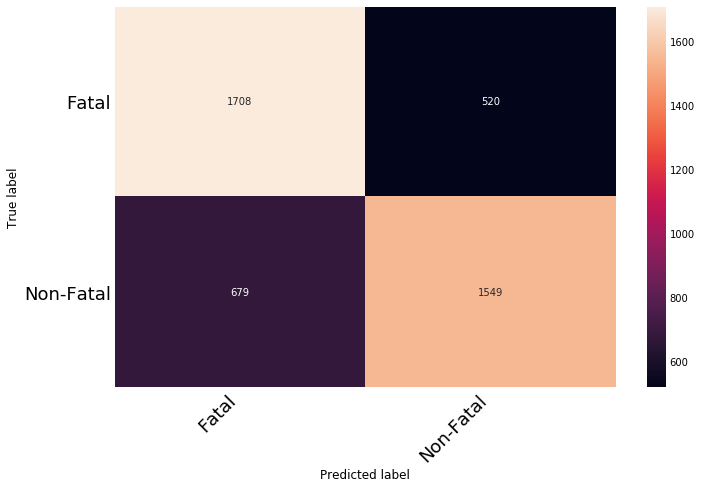

In [406]:
#Checking accuracy score on smoted model
from sklearn.metrics import confusion_matrix

RF_cross_val = cross_val_score(rf4, X_train, y_train, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF_smoted_last = confusion_matrix(y_smoted_last, predict_y_smoted_last)
RF_smoted_last = print_confusion_matrix(RF_smoted_last, ['Fatal', 'Non-Fatal'])

In [407]:
dt3.fit(X_smoted_last, y_smoted_last)
lm3.fit(X_smoted_last, y_smoted_last)
rf4.fit(X_smoted_last, y_smoted_last)
svc1.fit(X_smoted_last, y_smoted_last)
dc3.fit(X_smoted_last, y_smoted_last)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [408]:
models = [dt3, lm3, rf4, svc1, dc3]
names = ['Decision Tree SMOTE Last Features', 'LR SMOTE Last Features', 'Random Forest SMOTE Last Features',
         'SVC', 'Dummy']

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = model.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=2.0, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'FINAL TEST Scores Last Features')
    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

FINAL TEST Scores Last Features
Decision Tree SMOTE Last Features accuracy: 0.7269 precision: 0.3699 recall: 0.7152 f1: 0.4876 fB: 0.6027

FINAL TEST Scores Last Features
LR SMOTE Last Features accuracy: 0.7577 precision: 0.4014 recall: 0.6788 f1: 0.5045 fB: 0.5964

FINAL TEST Scores Last Features
Random Forest SMOTE Last Features accuracy: 0.7203 precision: 0.3631 recall: 0.7152 f1: 0.4816 fB: 0.599

FINAL TEST Scores Last Features
SVC accuracy: 0.7291 precision: 0.3722 recall: 0.7152 f1: 0.4896 fB: 0.6039

FINAL TEST Scores Last Features
Dummy accuracy: 0.4769 precision: 0.1645 recall: 0.4606 f1: 0.2424 fB: 0.3387



FINAL TEST Scores Last Features
Decision Tree SMOTE Last Features accuracy: 0.7269 precision: 0.3699 recall: 0.7152 f1: 0.4876 fB: 0.6027

FINAL TEST Scores Last Features
LR SMOTE Last Features accuracy: 0.7577 precision: 0.4014 recall: 0.6788 f1: 0.5045 fB: 0.5964

FINAL TEST Scores Last Features
Random Forest SMOTE Last Features accuracy: 0.7236 precision: 0.3665 recall: 0.7152 f1: 0.4846 fB: 0.6008

FINAL TEST Scores Last Features
Dummy accuracy: 0.5165 precision: 0.19 recall: 0.5091 f1: 0.2768 fB: 0.3811

In [409]:
feature_selection(X_smoted_last, y_smoted_last, 15)

,ExtraTrees FI,Random Forest FI,Recursive LogReg
0,Weather_Condition_IMC,Broad_Phase_of_Flight_INFLIGHT,Flight_Purpose_Aerial Application
1,Broad_Phase_of_Flight_LANDING,Weather_Condition_VMC,Flight_Purpose_Business
2,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Flight_Purpose_Ferry
3,Broad_Phase_of_Flight_TAXI,Weather_Condition_IMC,Flight_Purpose_Instructional
4,Broad_Phase_of_Flight_TAKEOFF,Flight_Purpose_Personal,Flight_Purpose_Other
5,Flight_Purpose_Aerial Application,Broad_Phase_of_Flight_TAXI,Flight_Purpose_Personal
6,Flight_Purpose_Instructional,Broad_Phase_of_Flight_TAKEOFF,Flight_Purpose_Positioning
7,Flight_Purpose_Personal,Flight_Purpose_Aerial Application,Weather_Condition_IMC
8,Flight_Purpose_Business,Flight_Purpose_Instructional,Weather_Condition_VMC
9,Flight_Purpose_Other,Flight_Purpose_Other,Broad_Phase_of_Flight_INFLIGHT


In [410]:
models = [dt3, lm3, rf4, dc]
names = ['Decision Tree SMOTE Last Features', 'LR SMOTE Last Features', 'Random Forest SMOTE Last Features', 'Dummy']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(X_smoted_last, y_smoted_last)
    preds = model.predict_proba(X_FINALtest)
    fpr, tpr, _ = roc_curve(y_FINALtest, preds[:,0], pos_label = 'Fatal')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0 1]
 [0 1]
 [1 0]
 ...
 [0 1]
 [0 1]
 [1 0]]


Text(0.5,1,'Comparing ROC Curves')

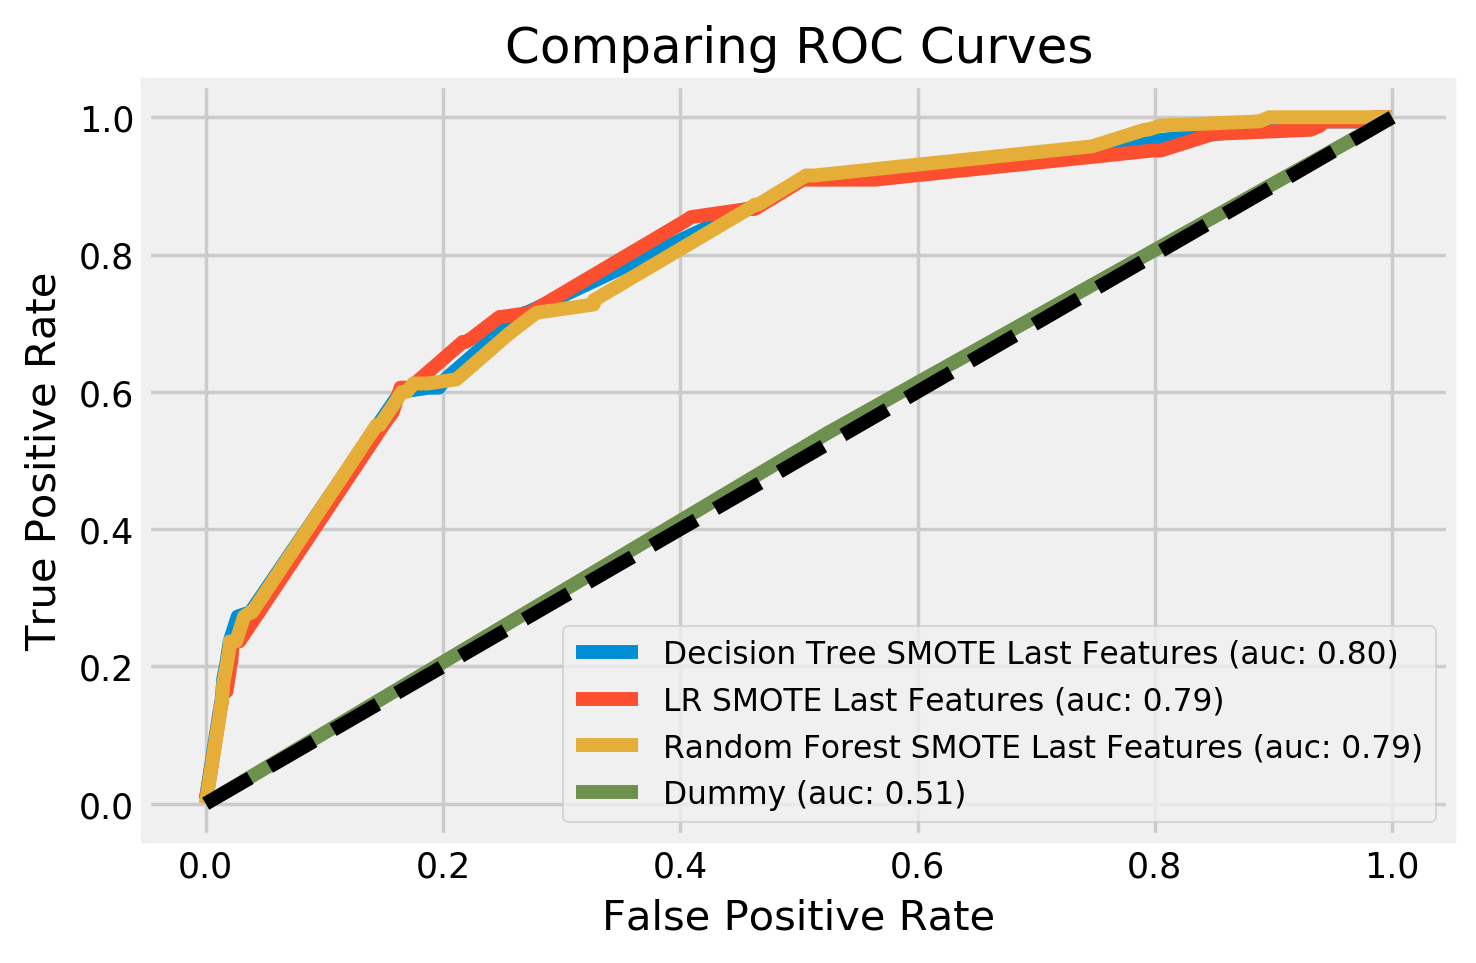

In [411]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves")

In [412]:
predict_y_FINALtest = rf4.predict(X_FINALtest)

In [413]:
collections.Counter(predict_y_FINALtest)

Counter({'Fatal': 325, 'Non-fatal': 583})

In [414]:
collections.Counter(y_FINALtest)

Counter({'Fatal': 165, 'Non-fatal': 743})

(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is 0.841


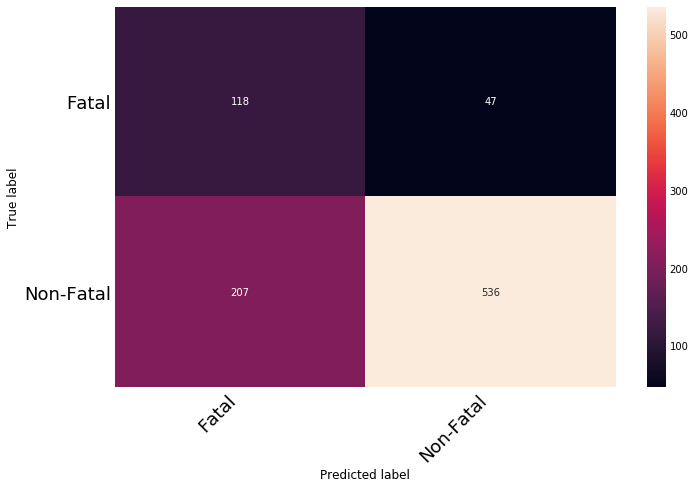

In [415]:
#Checking final accuracy of model

RF_cross_val = cross_val_score(rf4, X_FINALtest, y_FINALtest, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF_smoted_last = confusion_matrix(y_FINALtest, predict_y_FINALtest)
RF_smoted_last = print_confusion_matrix(RF_smoted_last, ['Fatal', 'Non-Fatal'])

In [416]:
Fatal_correct = 117 / (117 + 48)
Fatal_correct

0.7090909090909091

In [417]:
predict_y_FINALtest = lm3.predict(X_FINALtest)

In [418]:
collections.Counter(predict_y_FINALtest)

Counter({'Fatal': 279, 'Non-fatal': 629})

In [419]:
collections.Counter(y_FINALtest)

Counter({'Fatal': 165, 'Non-fatal': 743})

(SMOTE): The mean of 10 fold cross validation accuracy score on Logistic Regression model is 0.841


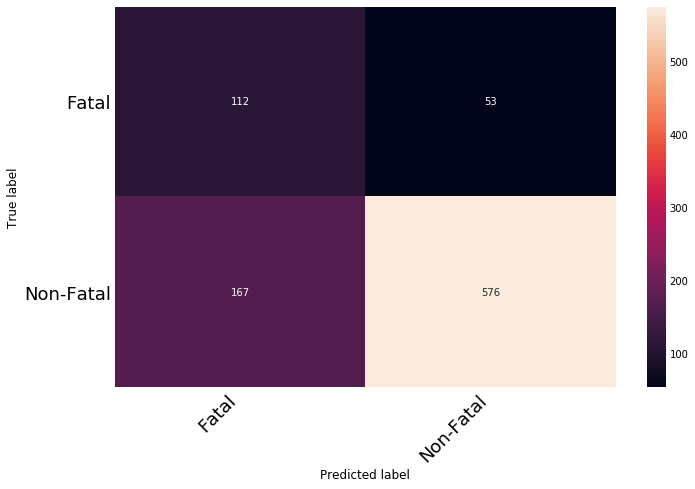

In [420]:
#Checking final accuracy of model

LR_cross_val = cross_val_score(lm3, X_FINALtest, y_FINALtest, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Logistic Regression model is', str(round(np.mean(RF_cross_val), 3)))

LR_smoted_last = confusion_matrix(y_FINALtest, predict_y_FINALtest)
LR_smoted_last = print_confusion_matrix(LR_smoted_last, ['Fatal', 'Non-Fatal'])

.315

In [421]:
predict_y_FINALtest = dt3.predict(X_FINALtest)

In [422]:
collections.Counter(predict_y_FINALtest)

Counter({'Fatal': 319, 'Non-fatal': 589})

In [423]:
collections.Counter(y_FINALtest)

Counter({'Fatal': 165, 'Non-fatal': 743})

(SMOTE): The mean of 10 fold cross validation accuracy score on Logistic Regression model is 0.841


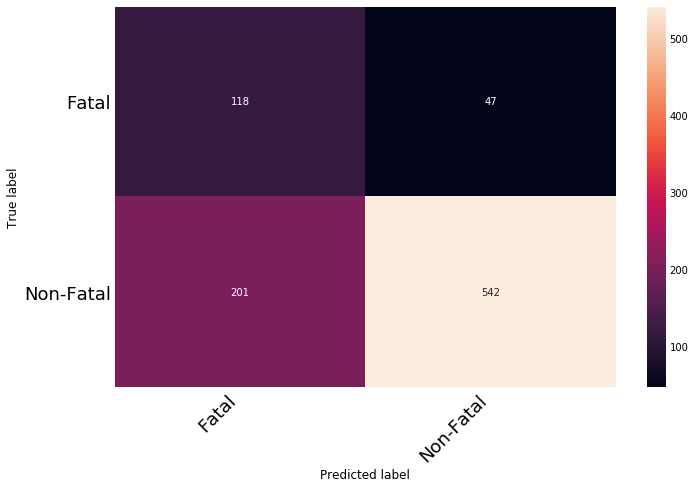

In [424]:
#Checking final accuracy of model

DT_cross_val = cross_val_score(dt3, X_FINALtest, y_FINALtest, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Logistic Regression model is', str(round(np.mean(RF_cross_val), 3)))

DT_smoted_last = confusion_matrix(y_FINALtest, predict_y_FINALtest)
DT_smoted_last = print_confusion_matrix(DT_smoted_last, ['Fatal', 'Non-Fatal'])

In [436]:
predict_y_FINALtest = svc1.predict(X_FINALtest)

In [437]:
collections.Counter(predict_y_FINALtest)

Counter({'Fatal': 317, 'Non-fatal': 591})

In [438]:
collections.Counter(y_FINALtest)

Counter({'Fatal': 165, 'Non-fatal': 743})

(SMOTE): The mean of 10 fold cross validation accuracy score on Logistic Regression model is 0.841


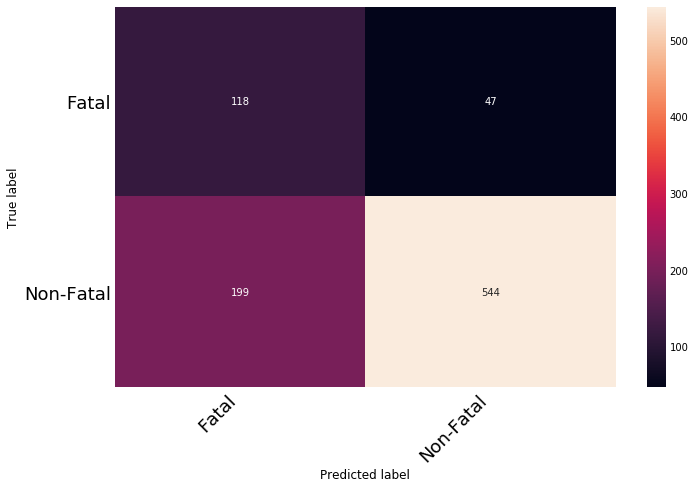

In [445]:
#Checking final accuracy of model

DT_cross_val = cross_val_score(svc1, X_FINALtest, y_FINALtest, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Logistic Regression model is', str(round(np.mean(RF_cross_val), 3)))

DT_smoted_last = confusion_matrix(y_FINALtest, predict_y_FINALtest)
DT_smoted_last = print_confusion_matrix(DT_smoted_last, ['Fatal', 'Non-Fatal'])
plt.savefig('/Users/brendenrossin/github/Project_Mcnulty/SVC.png', format='png', dpi=1000, bbox_inches="tight")

In [451]:
predict_y_FINALtest = dc3.predict(X_FINALtest)

In [452]:
collections.Counter(predict_y_FINALtest)

Counter({'Fatal': 447, 'Non-fatal': 461})

In [453]:
collections.Counter(y_FINALtest)

Counter({'Fatal': 165, 'Non-fatal': 743})

(SMOTE): The mean of 10 fold cross validation accuracy score on Logistic Regression model is 0.841


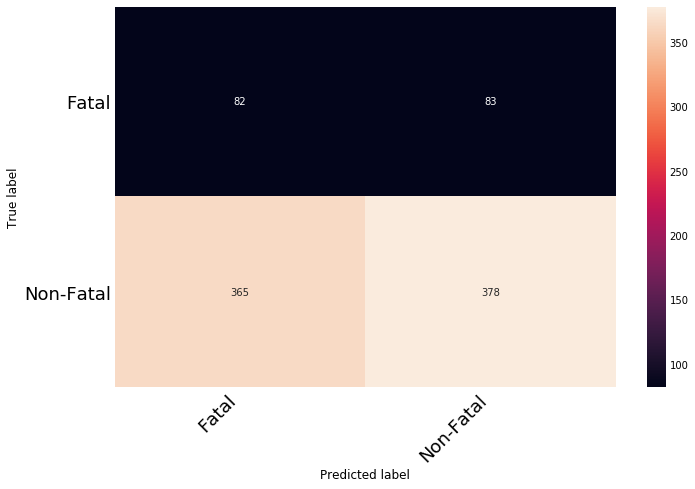

In [454]:
#Checking final accuracy of model

DT_cross_val = cross_val_score(dc3, X_FINALtest, y_FINALtest, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Logistic Regression model is', str(round(np.mean(RF_cross_val), 3)))

DT_smoted_last = confusion_matrix(y_FINALtest, predict_y_FINALtest)
DT_smoted_last = print_confusion_matrix(DT_smoted_last, ['Fatal', 'Non-Fatal'])
plt.savefig('/Users/brendenrossin/github/Project_Mcnulty/DUMMY.png', format='png', dpi=1000, bbox_inches="tight")

In [455]:
def rf_feature_selection(model, X, y, count):
    # RANDOM FOREST FEATURE IMPORTANCE
    model.fit(X, y)    
    importances = list(zip(model.feature_importances_, X.columns))
    importances.sort(reverse=True)
    RF_features = [x[1] for x in importances][0:count]
    
    feats = pd.DataFrame(
        {
         'Random Forest FI': RF_features
#          'PCA': PCA_features
        })
    
    return feats

In [456]:
rf_feature_selection(rf4,X_smoted_last, y_smoted_last, 15 )

,Random Forest FI
0,Broad_Phase_of_Flight_INFLIGHT
1,Broad_Phase_of_Flight_LANDING
2,Weather_Condition_IMC
3,Weather_Condition_VMC
4,Broad_Phase_of_Flight_TAXI
5,Flight_Purpose_Aerial Application
6,Flight_Purpose_Instructional
7,Flight_Purpose_Personal
8,Broad_Phase_of_Flight_TAKEOFF
9,Flight_Purpose_Business
